# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Models

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from import_file import *
from helpers.parallel_helper import *
load_libs()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0.
plt.rcParams['axes.ymargin'] = 0.

## 1.2 Read Data

In [2]:
# file_path= "./data/NCDC/us/baltimore/dat.txt" # time too short
# file_path= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# file_path= './data/NCDC/uk/middle_wallop/dat.txt' # good
# file_path= './data/NCDC/uk/southhamption/dat.txt' # high 0
# file_path= './data/NCDC/uk/bournemouth/dat.txt' 4?
# file_path= './data/NCDC/uk/tiree/dat.txt'  # try 4
# file_path= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# file_path= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# file_path= "./data/NCDC/uk/south_uist_range/dat.txt" 
# file_path= './data/NCDC/uk/marham/dat.txt' 
# file_path= "./data/NCDC/uk/holbeach/dat.txt"
# file_path= "./data/NCDC/uk/weybourne/dat.txt"
# file_path= "./data/NCDC/uk/cambridge/dat.txt"
# file_path= "./data/NCDC/uk/wattisham/dat.txt"
# file_path= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# file_path= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # 4 or 5?
# file_path= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# file_path= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # 2010-2014 has problem
# file_path= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # 2005-2009  may have problem, fit is good
# file_path= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem, but fit is generally good

# file_path= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# file_path= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# file_path= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# file_path= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# file_path= './data/NCDC/europe/ciampino/dat.txt' # try 4, bandwidth?
# file_path= "./data/NCDC/europe/holzdorf/dat.txt"
# file_path= "./data/NCDC/europe/neuburg/dat.txt"
# file_path= "./data/NCDC/europe/valladolid/dat.txt"
# file_path= "./data/NCDC/europe/barayas/dat.txt" # 
# file_path= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# file_path= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# file_path= './data/NCDC/europe/tenerife_sur/dat.txt'  # some directions are blocked

# file_path= "./data/NCDC/oceania/narrandera/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high 0
# file_path= "./data/NCDC/oceania/auckland_intl/dat.txt"  # Weird KDE shape, 4?
# file_path= "./data/NCDC/oceania/canberra/dat.txt" # high 0

# file_path= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# file_path= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# file_path= "./data/NCDC/cn/tianjing/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/tianjing/tianjing/dat.txt" # 16 sectors
# file_path= "./data/NCDC/cn/hefei_luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# file_path= "./data/NCDC/cn/南京lukou/dat.txt" 
# file_path= "./data/NCDC/cn/shijiazhuang_zhengding/dat.txt" 
# file_path= "./data/NCDC/cn/henan_gushi/dat.txt" # 16 sectors, fit not very good
# file_path= "./data/NCDC/cn/郑州xinzheng/dat.txt" # fit is not good
# file_path= "./data/NCDC/cn/nanning_wuxu/dat.txt" # recent 5 year has problem
# file_path= './data/NCDC/cn/macau/dat.txt'  
# file_path= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# file_path= "./data/cn_database/广州.txt" 
# file_path= "./data/cn_database/北京.txt" 

# file_path = 'TOP/hr_avg.csv' # High 0
# file_path = './data/asos/denver/hr_avg.csv' # few 0 

# file_path = './data/asos/bismarck_ND/hr_avg.csv' # try 4?
# file_path = './data/asos/bismarck_ND/minute_avg.csv' 
file_path = './data/asos/aberdeen_SD/hr_avg.csv' # only to 2012, good fit, try 2
# file_path = './data/asos/minneapolis/hr_avg.csv'

# file_path = './data/asos/lincoln_NE/hr_avg.csv' 
# file_path = './data/asos/des_moines_IA/hr_avg.csv'
# file_path = './data/asos/springfield_IL/hr_avg.csv'

In [3]:
if "cn_database" in file_path: 
    df = read_cn_database(file_path)
elif 'NCDC' in file_path:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
    integer_data = True
else:
    df = pd.read_csv(file_path, header=0, skipinitialspace=True, dtype={'HrMn':'object'})
    df['type']='default'
    df['wind_type']='default'
    df = df.dropna()
    integer_data = False
    knot_unit = True

In [4]:
df['time']=pd.to_datetime(df["date"].astype(str).map(str) + df["HrMn"], format='%Y%m%d%H%M')
df['HrMn']=df['HrMn'].astype(int)
df = df.query("(dir <= 999) & (speed < 100) & \
              (date >= 19700000) & (date < 20170000) ")

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


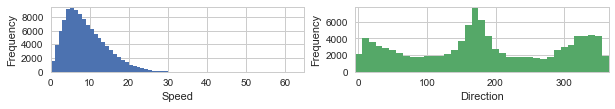

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
df['month'] = df['date']%10000//100
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date      speed_max          speed            dir  \
count  1.092650e+05  109265.000000  109265.000000  109265.000000   
mean   2.006375e+07      15.388826       8.939517     182.432078   
std    3.883085e+04      44.835895       5.314807      99.879562   
min    2.000010e+07       0.000000       0.000000       0.000000   
25%    2.003062e+07       8.000000       4.910000      95.710000   
50%    2.006111e+07      13.000000       7.940000     172.500000   
75%    2.010030e+07      19.000000      12.130000     276.500000   
max    2.013053e+07    2359.000000      64.200000     359.980000   

                HrMn          month   dir_windrose  
count  109265.000000  109265.000000  109265.000000  
mean     1149.735963       6.382803     184.784231  
std       691.784248       3.467497     107.063300  
min         0.000000       1.000000       0.000000  
25%       600.000000       3.000000     101.800000  
50%      1100.000000       6.000000     176.400000  
75%      1700.000000       9.000000     288.410000  
max      2300.000000      12.000000     359.990000

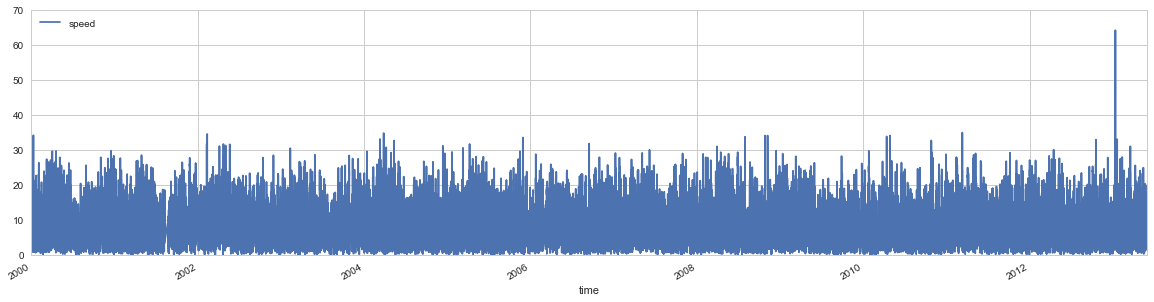

In [7]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

### 1.2.1 Unit Detection

In [8]:
if 'knot_unit' not in globals():
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
    knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

    if knot_unit:
        df['speed'] = df['speed'] * 1.943845
        df['decimal'] = df.speed % 1
        df.decimal.hist(alpha=0.5, label='knot')
        # need more elaboration, some is not near an integer
        df['speed'] = df['speed'].apply(lambda x: int(round(x)))
    plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')
    df.drop(['decimal'], 1,inplace=True)
print(knot_unit)

True


### 1.2.2 Sampling Type Selection

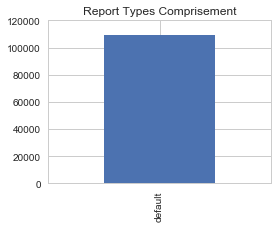

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

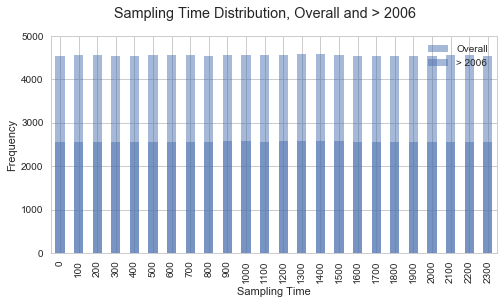

In [10]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5,label='Overall')
df.query('date > @MID_YEAR * 10000')['HrMn'].value_counts().sort_index().plot(
    kind='bar', alpha=0.5, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 4), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

[0]


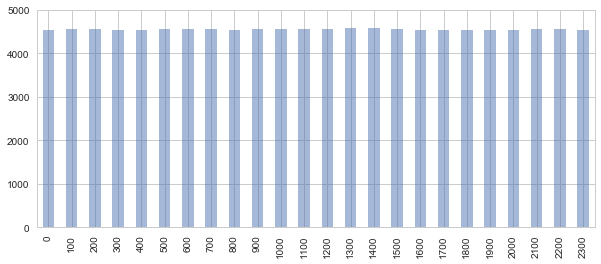

In [11]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_times = sample_time.value_counts()[sample_time.value_counts() > 2000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)
print(sample_times)

df['HrMn'].value_counts().sort_index().plot(kind='bar', alpha=0.5, figsize=(10, 4))

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [12]:
if integer_data:
    display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
    df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

#### 1.3.1.2 sudden increase in speed

date  speed_max  speed     dir  HrMn     type wind_type  \
105972  20130111      162.0  64.20  324.11  1900  default   default   
105971  20130111      136.0  40.13  339.89  1800  default   default   
90488   20110311       51.0  34.93  151.10  1800  default   default   
33443   20040327       51.0  34.77  288.96  1100  default   default   
105970  20130111      160.0  34.55  327.65  1700  default   default   
16749   20020211       53.0  34.52  146.81  1500  default   default   
16748   20020211       51.0  34.22  154.88  1400  default   default   
209     20000110       49.0  34.16  123.77  1700  default   default   
70979   20081106       48.0  34.09  113.76  2100  default   default   
70714   20081026       51.0  34.08  133.34  1000  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
105972 2013-01-11 19:00:00      1        125.89  24.07          46.48  
105971 2013-01-11 18:00:00      1        110.11   5.58         -24.07  
90488  2011-03-11 18:00:00      3        298.90   1.96           5.49  
33443  2004-03-27 11:00:00      3        161.04   6.17          24.53  
105970 2013-01-11 17:00:00      1        122.35  14.22          -5.58  
16749  2002-02-11 15:00:00      2        303.19   0.30           3.06  
16748  2002-02-11 14:00:00      2        295.12   3.60          -0.30  
209    2000-01-10 17:00:00      1        326.23   5.51           5.28  
70979  2008-11-06 21:00:00     11        336.24   3.90           1.82  
70714  2008-10-26 10:00:00     10        316.66   3.99           0.07

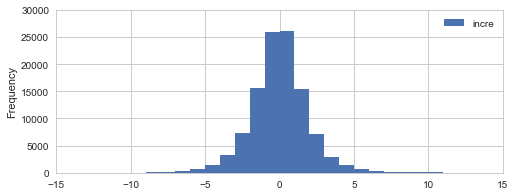

In [13]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [14]:
incre_threshold = 20 if knot_unit else 10
print('sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )')))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

# Check the max speed
display(df.sort_values(by='speed',ascending=False).head(10))
df.drop(['incre', 'incre_reverse'], 1, inplace=True)

sudden increase number 1


date  speed_max  speed     dir  HrMn     type wind_type  \
105971  20130111      136.0  40.13  339.89  1800  default   default   
90488   20110311       51.0  34.93  151.10  1800  default   default   
33443   20040327       51.0  34.77  288.96  1100  default   default   
105970  20130111      160.0  34.55  327.65  1700  default   default   
16749   20020211       53.0  34.52  146.81  1500  default   default   
16748   20020211       51.0  34.22  154.88  1400  default   default   
209     20000110       49.0  34.16  123.77  1700  default   default   
70979   20081106       48.0  34.09  113.76  2100  default   default   
83178   20100428       49.0  34.08  290.86  1300  default   default   
70714   20081026       51.0  34.08  133.34  1000  default   default   

                      time  month  dir_windrose  incre  incre_reverse  
105971 2013-01-11 18:00:00      1        110.11   5.58         -24.07  
90488  2011-03-11 18:00:00      3        298.90   1.96           5.49  
33443  2004-03-27 11:00:00      3        161.04   6.17          24.53  
105970 2013-01-11 17:00:00      1        122.35  14.22          -5.58  
16749  2002-02-11 15:00:00      2        303.19   0.30           3.06  
16748  2002-02-11 14:00:00      2        295.12   3.60          -0.30  
209    2000-01-10 17:00:00      1        326.23   5.51           5.28  
70979  2008-11-06 21:00:00     11        336.24   3.90           1.82  
83178  2010-04-28 13:00:00      4        159.14   0.51           3.17  
70714  2008-10-26 10:00:00     10        316.66   3.99           0.07

### 1.3.2 0 Speed

In [15]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print(delete_zero, null_wind_frequency)

False 0.0156712769934


### 1.3.3 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [16]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
if integer_data:
    SECTOR_LENGTH = 360/len(effective_column) 
else: 
    SECTOR_LENGTH = 10
print(len(effective_column), SECTOR_LENGTH)

0.00      1
0.02      2
0.03      1
0.06      1
0.07      1
0.08      1
0.09      1
0.10      1
0.11      1
0.12      5
0.13      3
0.14      4
0.15      2
0.17      1
0.18      3
0.19      1
0.20      2
0.21      1
0.23      3
0.26      1
0.27      1
0.28      4
0.29      2
0.30      3
0.31      5
0.32      1
0.34      1
0.35      2
0.36      3
0.37      2
         ..
359.64    2
359.65    1
359.66    2
359.67    2
359.68    1
359.69    1
359.70    3
359.72    1
359.73    2
359.74    3
359.76    1
359.77    2
359.78    2
359.79    3
359.80    2
359.82    3
359.84    1
359.85    1
359.86    3
359.87    3
359.88    2
359.89    3
359.90    3
359.91    1
359.92    1
359.93    1
359.94    1
359.96    2
359.97    2
359.98    1
Name: dir, dtype: int64

1 10


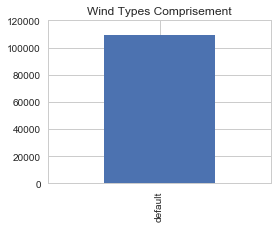

In [17]:
df=realign_direction(df, effective_column)
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.4 Time Shift Comparison

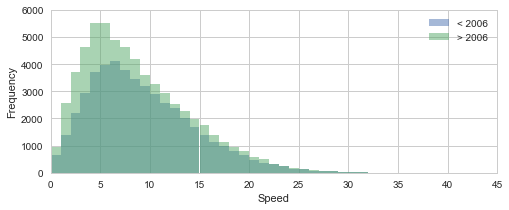

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, df.speed.max() + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

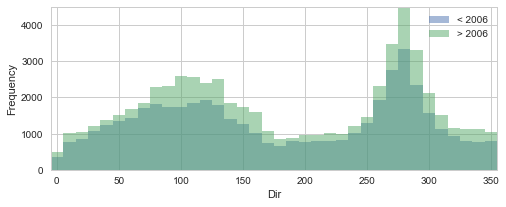

In [19]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

2000 - 2004


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


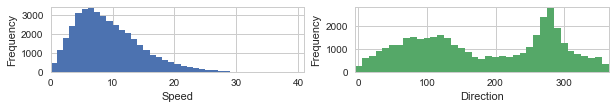

2005 - 2009


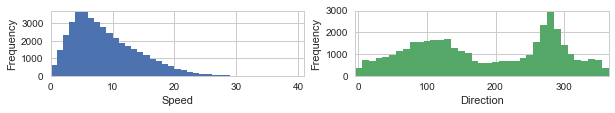

2010 - 2013


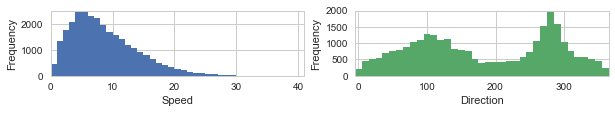

In [20]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [21]:
if integer_data:
    df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

In [22]:
if integer_data:
    if delete_zero:
        redistribute_method = 'down'
    else:
        redistribute_method = 'up'

    df, speed_redistribution_info = randomize_speed(df, redistribute_method)

## 1.5 Generate (x,y) from (speed,dir)

In [23]:
# Cook orientation
# df['dir']= (df['dir'] + 180)%360

In [24]:
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [25]:
## Summery of the data selection
print('Knot unit?', knot_unit)
print('Report type used:', report_type_most_used)
print('Sampling time used:', sample_times)
if 'speed_redistribution_info' in globals():
    print('Speed redistribution info:', speed_redistribution_info )

df_all_years = df # for later across-year comparison
df = df_all_years.query('(date >= 20100000) & (date < 20150000)')
# df = df.query('(HrMn == 0) and (speed >= 0.5) and (date%10000 > 900) and (date%10000 < 1000)' )
df.describe()

Knot unit? True
Report type used: default
Sampling time used: [0]


date     speed_max         speed           dir          HrMn  \
count  2.878200e+04  28782.000000  28782.000000  28782.000000  28782.000000   
mean   2.011311e+07     14.219373      8.687160    182.757129   1150.145925   
std    1.000365e+04      8.090569      5.362492    100.198360    690.920391   
min    2.010010e+07      1.000000      0.020000      0.060000      0.000000   
25%    2.010111e+07      8.000000      4.630000     96.642500    600.000000   
50%    2.011092e+07     13.000000      7.630000    169.990000   1200.000000   
75%    2.012073e+07     19.000000     11.820000    277.707500   1700.000000   
max    2.013053e+07    160.000000     40.130000    359.970000   2300.000000   

              month  dir_windrose             x             y  
count  28782.000000  28782.000000  28782.000000  28782.000000  
mean       6.105448    186.167199     -0.262583      0.504867  
std        3.496075    107.464964      5.822260      8.366787  
min        1.000000      0.000000    -31.439064    -31.846168  
25%        3.000000    105.052500     -3.115382     -4.924735  
50%        6.000000    176.060000      0.242468      0.332379  
75%        9.000000    290.907500      3.188066      6.018183  
max       12.000000    359.980000     37.683445     28.914194

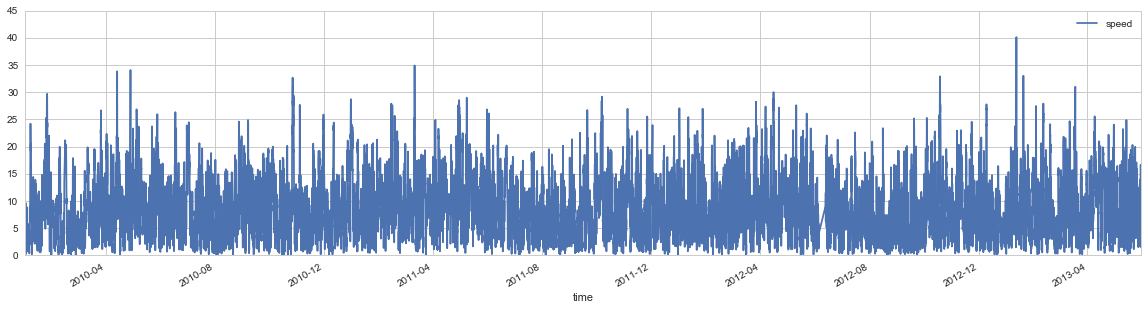

In [26]:
df.plot(x='time', y='speed',legend=True,figsize=(20,5))

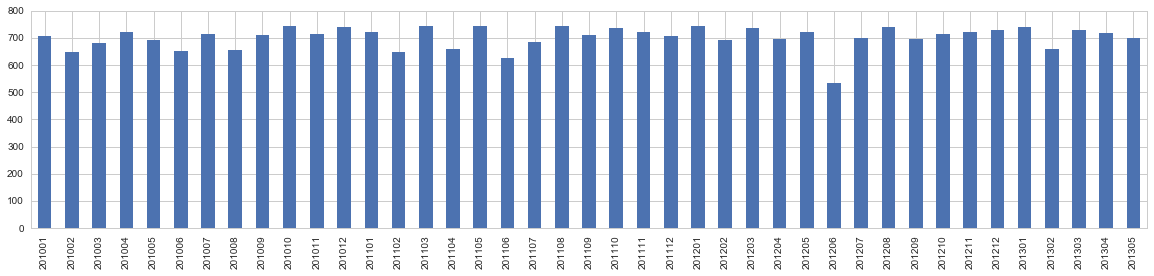

In [27]:
df['date'].apply(lambda x: str(x)[:-2]).value_counts().sort_index().plot(kind='bar', figsize=(20,4))

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


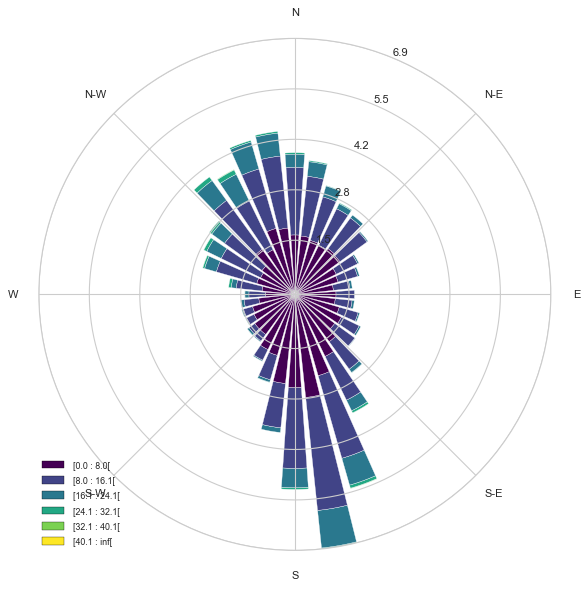

In [28]:
# 90 degree is east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [29]:
if len(df) > 1000000:
    bins=arange(0,362)
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min')
    
    df = df_all_years.sample(n=500000, replace=True)    
    df['dir'].hist(bins=bins, normed=True,alpha=0.5,label='min resmapled')
    plt_configure(legend=True, figsize=(20,4))

In [30]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 1. Histogram comparison
fig = plt.figure()
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data', normed=True)             
plot(x, y_weibull, '-', color='black',label='Weibull')   
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF', legend=True)

# 2. CDF comparison
fig = plt.figure()
plot(log(x), log(-log(1-y_ecdf)),'o', label='ECDF')
plot(log(x), log(-log(1-y_cdf_weibull)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'}, figsize=(4,3))
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARYAAADPCAYAAAAwC/4cAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzt3XlcVPX+x/HXLIKyCCJKakGJ4ZILiKm5YBfTQm8bqBBG
esVcyzRTyS2vegXLMi3XzPsrlCRtuXIrySXFzAVRNDPKi11uiqmABAMa4MzvD2KSVFyY4cyc+Twf
Dx4yc5hzPt+0N9/zPd/zPRqTyWRCCCEsSKt0AUII9ZFgEUJYnASLEMLiJFiEEBYnwSKEsDgJFiGE
xemVLqC2MjIylC5BCIcVHBx8zfftPljg+o2zFxkZGXbfBpB22JK6aENNv9TlVEgIYXESLEIIi5Ng
EUJYnCrGWCwpKTXrqveiH26jQCVC2C8JlpsgYSPErZFTISGExUmwCCEsToJFCBszbNgwjh49CkBZ
WRnBwcGsWbPGvD0mJobvv//+qs+lpaWRnJzMqVOnmD179k0fr2fPnub9Zmdn17L6ShIsQtiYnj17
cvDgQaByElqvXr3YtWsXAL/99hunT5+mTZurx/hCQkKIjIys01qvRwZvhajBlClT2Lhxo0X3OXjw
YF577bXrbu/RowfLly9nxIgR7Nq1i8GDB7No0SKKi4v57rvv6Nq1K+np6SxevBidTsddd93F3Llz
SUlJ4eTJk0RFRVFUVMSYMWPIz8/nwQcfZPz48cTFxTFgwABCQkJIS0vj888/JyEhwaJtqyI9FiFs
TLt27Th58iQmk4n09HS6du3KAw88wDfffMOBAwfo1asXs2bN4u2332bdunX4+PjwySefVNvHpUuX
eO2119iwYQO7d+8mK+vqK5vWJD0WIWrw2muv1di7sAatVkubNm1IS0ujSZMmODk5ERISws6dO8nK
ymLo0KHMmjWLiRMnApUh0qNHD/z8/Mz78PPzw93dHYAOHTrw008/VTuGtZe6lh6LEDaoZ8+erFq1
it69ewOVN9oeP34co9FIo0aNuOOOO1i+fDmJiYmMGTOG7t27V/v86dOnKSkpoaKigqNHj3Lvvffi
5OTE+fPnATh+/LhV67daj8VoNDJnzhx++OEHnJycmD9/frVE3bFjB8uWLUOv1xMREcGQIUMoLy8n
Li6O06dPo9VqmTdvHv7+/tYqUQib1aNHD2bOnMmrr74KgJOTE+7u7rRt2xatVsuMGTMYNWoUJpMJ
V1dXXn31Vc6cOWP+vJubG5MmTaKgoIABAwbQqlUrBg8ezPTp00lJSeHuu++2av1WC5Zt27ZRVlZG
cnIymZmZJCQksGLFCgDKy8uJj49n06ZNNGjQgKeeeorQ0FAyMzOpqKhgw4YN7NmzhzfffJO33nrL
WiUKYbNatGjBDz/8UO295cuXm7/v1asXvXr1qrY9PDzc/H1CQsJVyyZ06NCBlJSUq461Z88eABIT
E2tddxWrBUtGRoa5GxcYGMixY8fM27Kzs/H19cXDwwOo7Oalp6cTEBDA5cuXMRqNGAwG9HoZAhLC
Hlnt/1yDwYCbm5v5tU6no6KiAr1ej8FgMA8sAbi6umIwGHBxceH06dOEhYVx4cIFVq5ceVPHsuQq
crm5v97wZ8p+u8iUKe9y+vRpnn/+eZycnGp9XLWshCftsB1KtsFqweLm5kZJSYn5tdFoNPdA/ryt
pKQEd3d3/u///o9evXoxefJkzpw5w7Bhw0hJScHZ2bnGY1lypawf8q5/Wa6osIAvN69ja0oShuLK
ACq85MTTo+OA278xUQ0rloG0w5aodgW5zp07k5aWBkBmZiYBAQHmbf7+/uTk5FBYWEhZWRkHDx4k
KCiIhg0bmnsyHh4eVFRUcPnyZWuVeNPOnfmZf749lwnPhPJJ0grQaHhy6Dia3XkPX3zyHkcO7la6
RCFsitV6LP369WPPnj1ERUVhMplYsGABKSkplJaWEhkZSVxcHLGxsZhMJiIiIvDx8WH48OFMnz6d
6OhoysvLmTRpEi4uLtYq8YZ+OvEd/970Lvt3p2IyGvFu2pwBEX+jz8Ph1K/vQpcH+jJ7YhSrXp9O
/IpPFatTCFtjtWDRarXMnTu32ntXXjoODQ0lNDS02nZXV1eWLFlirZJuislk4rvDe0nZuIZjh/cC
4NuyDX8dHEv3kEfQ6f74T3Z3q3ZE/m0SSe+8yurXp9PQYyUajaba/mTdFuGI5LLLFcrKylgQ9zeO
H9kPQLtO3Xh08Eg6BPe8KjCqhD05jKMZX5OZnsbWlCT6Pza0LksWdeBaC33Vxs38stm/fz8TJ06k
VatWmEwmKioqeOaZZxgwYMA1fz43N5esrKyrflkrRYLlCrt27eL4kf20vi+YoaOm4d+6ww0/o9Vq
GTM5npfHPUHSO6/SpsP9+N4TcMPPCXEj3bt3Z/HixUDlBY6YmBjuuece2rZte9XP7tu3j5MnT0qw
2KLPPvsMgPCh424qVKo0atyUUZP+wetzxrEsYTLzlm7Eybm+tcoUDsjV1ZXIyEg+//xz1q1bxy+/
/MK5c+cIDQ1lwoQJrF69mkuXLhEUFIS7uzvx8fHmq6+vv/4699xzT53WK/cKXeHzzz+nfgMXWrfv
csuf7dz9L/R7NJpTOf/hg3cXWaE64egaN27M8ePHCQwM5N1332XTpk1s2LABnU7HqFGj+Otf/0rf
vn05ceIE48ePJzExkf79+7Nly5Y6r1V6LL87ceIEJ06coEuPvtS7zQlv0SOn8P3RA3y5eT0dgnvS
udtfLFylcGS5ubkEBQXx7bffsm/fPtzc3CgrK7vq53x8fHjvvffYtm0bZ8+epXPnznVeq/RYfvfF
F18A0On+kNveh5NzfcZPW0S9ek6sfmMGF/LPWao84eAMBgMbN27E3d0dd3d3Xn/9dUaMGMGlS5cw
mUxotVqMRiMAs2bNYvTo0SQkJNC0aVOrL5FwLdJj+V3V+Erg/X1qtR/flq2Jin2JxJULWPX6dMZG
paHVSn6LW7dv3z5iYmLQarVcvnyZ559/nnvuuYfJkyeTmZmJk5MTfn5+nDt3joCAAFasWMF9993H
Y489xty5c/Hy8sLb25tz5+r+F5wEC5Uj7jt37qRTp054efvUen8PP/40RzN2cyR9N0uWLGHSpEkW
qFIoRYm5SN26dWPv3r3X3LZ58+ar3vPx8SE1NRWAgQMH0r9/f0VvS5BfpVSuDVNWVnbdOQK3SqPR
MHpyPB6NvJk2bRqHDx+2yH6FsBcOHSxJqVkkpWbx5sr1ANTzbm+xfXt4Nmb05AWUl5cTHR1NaWmp
xfYthK1z6GCByin8R9LTcHXzoFWbjhbdd6cuvZk4cSJZWVn8/e9/t+i+hbBlDh8sp3JOkH/+DB2D
e1a7D8hS4uPjadasGStXrqS4uNji+xfCFjl8sGQeqHwQVGDX2l0Nup769eszbtw4ioqKeO+996xy
DCFsjQRLehoajYaOwb1u/MO3afTo0Tg7O7N06VLzXAMh1Myhg6XEUMSP3x2mZesONPT0stpxmjRp
QnR0NCdOnDBPxBNCzRw6WL49tAej8TJBtZwUdzNeeOEFAMXXmxGiLjj0BLnMA5VLZ1prfAWuXMvD
mbYd7mfr1q0cP36cdu3aWe2YQijNYXssRqORIwd349HIGz//q9e3sIaHn4gBYOnSpXVyPCGU4rDB
kpGRQVFhPoH3h9TZvTzB3UO5++67ef/99ykoKKiTYwqhBIcNls8//xyo3d3Mt0qr0/Hcc89x8eJF
1qxZU2fHFaKuOXSw6HR6OnTuUafHjY2NxdXVlbfffpuKioo6PbYQdcUhg+XcuXOVj3S9rzMuru43
/oAFeXp6Mnz4cH7++Wc++eSTOj22EHXFIYNly5YtmEwmAuvwNOhKzz//PCCXnoV6OWSwVI2vKBUs
rVu3JiwsjD1

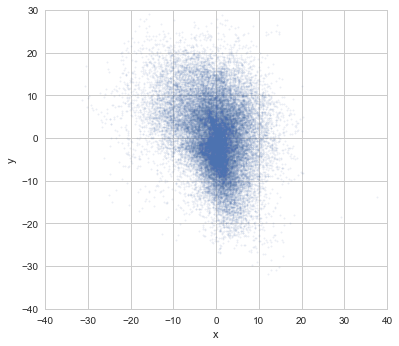

In [31]:
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2)
plt.gca().set_aspect('equal')

## 2.2. Overview by Direction

In [32]:
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 10

In [33]:
original_incre, incre = SECTOR_LENGTH, rebinned_angle
start, end = -original_incre/2 + incre/2, 360

max_speed = df.speed.max()
max_count = max_count_for_angles(df, start, end, incre)
plot_range = [0, max_speed, 0, max_count*1.05]

for angle in arange(start, end, incre):
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)   
    
    fig = plt.figure()
    title ='%s (%s - %s), %s' % (angle, start_angle, end_angle, len(sub_df)) 
    sub_df['speed'].hist(bins=arange(0, max_speed), alpha=0.5, label='Data')
    plt.axis(plot_range)
    plt_configure(figsize=(3,1.5), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAANIAAAB6CAYAAADK1g3BAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAEOZJREFUeJzt3XtMk9cbB/BvoSDEqrAwcdnEgQwZaBFv6BiYTY1zDBVv
Uy5m4piYmIHuAiogWnToposxyBAkOpyiU3AmXrZpUDMZbiDqwGtVUIdyUXBU7uX8/iC8PysVWjjY
l/J8EhL7ntP2KfXLad/3vOeVMMYYCCFdYmLoAggxBhQkQjigIBHCAQWJEA4oSIRwQEEihAOjClJj
YyPWrVsHDw8PeHh4YNOmTVCr1dz6A4BKpYKvry+qqqpe2CcmJgbDhg3T+Fm3bt0L+9+8eRMBAQFw
c3ODj48Pzp492/GL7cDixYvb1LBz584X9s/NzYWfnx/kcjlmz56Nf/75R2j77bffsHLlyk7XcuPG
DQwfPhznz5/X2P7HH39g+vTpkMvlmDFjht7tosKMSHx8PJsyZQrLz89n586dY56eniwhIYFbf8YY
UygU7Icffmi3z/z589n27dtZWVmZ8FNdXa21b21tLfP29mbR0dFMqVSyhIQENmLECFZUVNTxC26H
l5cXy8zM1KihpqZGa9+HDx8yd3d3tnXrVqZUKllsbCzz8PBgT548EfrMnj2bnT9/Xu86mpqa2KxZ
s5iTkxPLyckRtl+9epW5urqyhIQEVlRUxL799ls2atQoVlpaqlO72BhNkOrq6pibmxs7efKksC0j
I4NNmDCBqdXqLvdnjLGysjI2cuRIVlVV1W4t48aNY2fOnNGp7szMTDZhwgTW0NAgbAsMDGTx8fE6
3V+b6upq5uTkxJRKpU79t23bxmbOnCncbm5uZpMmTWJpaWkadQYGBupdS2JiIgsICGgTpOXLl7PQ
0FCN5/Tz82O///67Tu1iYzQf7a5evYra2lqMGzdO2DZmzBg8evQId+/e7XJ/ANi/fz/c3d0xYMCA
F9ZRXl6Oqqoq2Nvb61T3hQsX4O7uDjMzM2Hb2LFjkZ+fr9P9tVEqlZBKpbCzs9Opf35+PsaOHSvc
lkgkGD16tEYN7733HvLz83H9+nWd67h58yZ2796NtWvXtmn7888/MW3aNI3nzMjIwOTJk3VqFxuj
CVJpaSksLS3Rr18/Ydurr74KAHj48GGX+wPA6dOn4eXl1W4dSqUSEokEycnJmDhxIj788EOkpqai
ublZa/+ysjIMHDhQY5uNjQ1KS0vbfZ6OapDJZIiMjMS7776LGTNmIDMz84X9dalhwIABGDFiBM6c
OaNTDWq1GpGRkQgLC8OgQYM02qqrq/H48WOYmZlh2bJleOedd7BgwQIhuB21i5HRBKm2thZ9+vTR
2GZubg4AaGho6HJ/tVqNK1euwNHRsd06bt++DRMTE9jZ2WHHjh0IDg5GQkICUlJS9KpbWw26unXr
Furq6jBhwgSkpKRg5syZiI6OxtGjR7tUg6OjIwoKCnSqISUlBTKZDB9//HGbtqdPnwIA4uLihBpH
jBiBTz75BPfv3++wXYykhi6AFwsLizZvfOttS0vLLvevqqqCWq2GtbW1sO3TTz9FXl6ecPvo0aPw
9/eHj48PrKysAADDhg3DkydPsGvXLnz22Wc612FhYaH1dfr4+KCkpES4re2v9JdffonQ0FDhI6iz
szPu3buHtLQ0+Pj4dLoGKysr3L59W2tdz1IqlUhNTcXBgwchkUjatEulLf/tPvroIwQEBAAAXFxc
kJOTg59//hlBQUHtti9fvrzDGl42ownSoEGDUFNTA5VKBZlMBqDl+woA2Nradrl/63+IZz+irV+/
HnV1dcLtgQMHQiKRCCFq5ejoiIqKCqjVapiammq02draCs/bqry8XGsNALBjxw40NTVpbWtlamra
5nvc0KFDcfr0aa39da1BrVbDxKTjDzEnTpxAdXU1pk+frrE9JCQEM2fORExMDMzMzNqM7g4ODigp
KYGVlVW77WJkNB/tnJ2dYWlpqTFC5ObmwsbGRuuXbn37W1tbQyqVorKyUthma2uLIUOGCD9SqRTr
16/HokWLNO5bUFCAN998s02IAMDd3R35+fka4cjNzYW7u7vW1/n6669rPKc2y5Ytw+rVqzW2FRYW
wsHBQWt/d3d35ObmCrcZY8JOkGdVVlYK3yPbExgYiOPHj+Pw4cM4fPgw9u3bB6Dlo1pYWBikUinc
3NxQWFiocb9bt25h8ODBHbaLkqF3G/KkUCjY+++/z3Jzc1l2djbz9PTUOOZTWVnJKisrde7/vDlz
5rCkpKR2a8jJyWHOzs4sKSmJFRcXs8zMTDZy5Ej2yy+/MMZajquUlZWx2tpaxhhjKpWKeXp6ssjI
SKZUKtn27duZXC5nd+/e7fTvITMzk7m4uLCDBw+y4uJitmvXLubq6sr+/vtvxhhj9fX1rKysjNXX
1zPGGHvw4AFzc3NjmzdvZkqlkq1du5aNHz+e/ffffxqP6+fnx1JTUxljLce/ysrKWFNTU4f1qFSq
Nru/s7KymKurK0tPT2dFRUVs48aNzM3Njd27d0+ndrGRMGa4E/ueHQ14aGhowO7du5GTkwMzMzN4
e3tj/vz5wscRhUIBAIiOjtap//MyMjJw8+ZNREREtFvHX3/9hYyMDDx48ADW1tbw9fXFpEmTALR8
ZAoLC8OSJUswceJEAEBRURFSU1NRXFwMW1tbBAYGQi6Xd+l3cfLkSRw/fhwVFRWwtbXF3LlzhV3c
V65cQVxcHKKiouDi4gKgZdT88ccfUVpaCjs7OyxatEhjBKupqcGSJUuwadMmvPbaazhz5gySkpKw
devWDkepuro6BAcHazwfAGRnZ+PQoUOoqKjA4MGDERgYCGdnZ53bu9vo0aN172zIFOfm5hry6XXW
WufDhw+Zm5sbKy8vN3BF2nXn7zM9PZ0tXLhQY1tISIjev4ue9p7rymi+I70Mtra28PPzw/79+w1d
ykvFGMO+ffuwdOlSYduFCxdgYmICGxsbA1YmHhQkPa1YsQLHjh1rd9KqsTlx4gScnJwwfvx4YZtc
LkdiYqIBqxIXo9n9/bL069fvhQc2jdW0adM0pusA/z8WRFrQiEQIBxQkQjigIBHCAQWJEA50CtKl
S5eEiYRXrlyBl5cXgoKCEBQUhGPHjgEADhw4gFmzZmHevHnIysrqvooJEaEOd70kJyfjyJEjwozo
wsJCLFq0CMHBwUKf8vJypKWl4dChQ6ivr4e/vz88PT2F0xIIMXYdjkh2dnbYtm2bcLugoACnT59G
QEAAVq1aBZVKhcuXL8Pd3R3m5ubo168f7OzscO3atW4tnBAx6XBEmjp1qsbJVHK5HHPnzsXw4cOR
mJiIhIQEODs7a5xp2rdvX6hUKp0K4D3frrtQnfz0hBr1pfdRtSlTpqB///7CvxUKBcaMGSOc1Qi0
nAH5bLDao9fEQAPJy8ujOjnpCTUC+odd7712ixcvxuXLlwG0LFDh6uoKuVyOvLw81NfXo7q6Grdu
3YKTk5O+D01Ij6X3iBQbGwuFQgEzMzPY2NhAoVBAJpMhKCgI/v7+YIxh+fLlbdYAIMSY6RSkN954
AwcOHAAAuLq6Ij09vU2fefPmYd68eXyrI6SHoAOyhHBAQSKEAwoSIRxQkAjhgIJECAcUJEI4oCAR
wgEFiRAOKEiEcEBBIoQDChIhHFCQCOGAgkQIBxQkQjigIBHCAQWJEA70XteuuLgYCxYsgL+/P9as
WSNcU5XWtSO9WYdBSk5ORlRUFOrr6wEA33zzDcLDw7F3714wxnDq1ClhXbv09HTs3LkTW7Zs6dLl
7QnpaTo81bx1Xbuvv/4aQMsCkePGjQMAeHt749y5czAxMRHWtTM3NxfWtdPl8o09ZWkmqpOfnlCj
vvRe144xBol

## 2.3 Overview by Month

In [34]:
month_incre = 1
current_df = df.query('speed>=1')
for month in arange(1, 12+month_incre, month_incre): 
    end_month = month+month_incre
    sub_df = current_df.query('(month >= @month) and (month < @end_month)')
    if len(sub_df) > 0:
        if month_incre == 1:
            title = 'Month: %s' % (month)
        else:
            title = 'Month: %s - %s ' % (month, end_month-1)
        ax = WindroseAxes.from_ax()
        ax.bar(sub_df.dir_windrose, sub_df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=plt.get_cmap('viridis'))
        plt_configure(figsize=(3,3), title=title)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOwAAADxCAYAAADIm1tRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAMTQAADE0B0s6tTgAAIABJREFUeJzsnXl4XGX59z+z7zOZyb5vTZOmTfeFLtCVtkChgoKogAiC
sgiICihgFUFA+1Y2AZWdX1GoyFJBEFqgLW3pQqFLmjT7vk4ymX0/7x9xpg1J2qQ5War5XleuqzNz
znOec3q+z3Pvt0QQBIFxjGMcZwSkoz2BcYxjHAPHOGHHMY4zCOOEHcc4ziCME3Yc4ziDME7YcYzj
DMI4YccxjjMI44T9H8C45+6/B+OEHQEsW7aM/Px8HnrooT5/b2hoID8/n/z8fDo6OkS99ocffsi6
deuinx9//HFmzJgh6jWcTidLly7lvffeE3XccfTGOGFHCBKJhA8++KDP395///1hu+6LL75IS0vL
sI3vdDq58cYbaWxsHLZrjOM4xgk7QpgxYwb19fUUFxf3+u29994jPz9/FGY1NOzZs4dLL72UkpKS
0Z7K/wzGCTtCmDRpEunp6b1208bGRg4dOsTq1at7nfPBBx/w9a9/nenTp7N48WIeeeQRgsFg9Pdl
y5bxl7/8hXXr1jF37lxmzpzJnXfeidPpBODKK69kz549fPzxx+Tn51NfXx89991332XVqlUUFRVx
ySWX8Pnnn0d/q6+vJz8/n8cff/yk93TTTTcxceJEnnnmmdN6JuMYPMYJO4JYuXJlL7H4/fffZ9q0
aSQlJfX4/tVXX+Xmm29m6tSpPPHEE1xxxRU899xz3HXXXT2O+9Of/oTdbmfDhg3cdtttvPPOOzz1
1FMArFu3jsLCQmbOnMmrr75KQkICAB6Phz/84Q/ccsstPProo3g8Hn70ox9FF4OEhAReffVVLr30
0pPez8aNG3n00UexWCxDei7jGDjkoz2B/yWsXr2aZ599loqKCnJzc4Fucfi8887rcVwoFOKRRx7h
ggsuiBqMFi1ahMFgYN26dXz/+9+noKAAgKSkJDZs2IBEImHRokV88sknPPPMM8ydO5fFixej1+vR
arXcfvvtvPTSS0C31fj3v/8906dPByAYDPKjH/2I8vJyCgoKUCqV0d9OhokTJ4r2bMYxMIzvsCOI
oqIikpOT+fe//w1AU1MTBw8eZNWqVT2Oq6yspKOjo5eYfMEFFwCwb9++HmNKJJLo5/j4eKB7d3U4
HH3OQyaTMXXq1Ojn1NRUgH6PH8fYwThhRxASiaSHWPz+++8zdepUkpOTexzX1dUFQGxsbI/vDQYD
SqUyqqMCaDSaXteQyWQsWrSIBx98sM95qFQqpNLj//WRf4fD4dO8s3GMFMYJO8JYuXIlR44cob6+
nvfff7+XOAwQExMDgNVq7fG93W7H7/dHfz8Z7rrrLnbt2oXNZhNn4uMYExgn7Ahj5syZxMfH87e/
/Y0vv/yylzgMkJ2djdls7hWI8O6770bHOBX0ej2/+c1vqK6u7mFZHseZjXGj0whDKpVy7rnn8sIL
L0R12q9CJpNx880385vf/AaTycTy5cspLS3l8ccfZ/Xq1QM29ixatIj4+HgOHDiARqPB5/MN6Dy/
309xcTFJSUm9rNfjGF2M77CjgJUrVxIIBPr0vUZwxRVX8MADD/DZZ5/xwx/+kI0bN/K9732P9evX
D+pa9913Hx6Ph/b2dsrLywd0TmtrK9/85jfZtGnToK41juGHZLym038X6uvrueqqq9i6dWv0ux07
dnDttdeyZcsW0tLSRnF24xgqxgk7jnGcQRgXiccxjjMI44QdxzjOIIwTdhzjOIMw7tb5L0A4HCYU
CkUrSwiCEP23RCLp8SeTyXqEMo4G3nrrLf785z8DcM4553DnnXf2+H3Xrl08/PDDhEIhUlNTefjh
hzGZTKMx1TGHcaPTGIYgCAQCAfx+P4FAIPrn8/mi3wWDwUGHFMpkMhQKBQqFAqVSiVKpjH5WKBSo
VCrk8uFZyz0eD4sXL+Zf//oXJpOJb33rW/z4xz9mwYIFQHfiw9KlS3n++efJzc1l/fr1SKVSbr/9
9mGZz5mG8R12jEAQBPx+P263G5fLhcvlwu12Ew6HkUql0T+5XI5cLkej0WAymVCpVFHSRUgmlUoJ
hUJ88cUXTJ8+HYlEgiAIBINB/H4/Pp8vSvrINSPED4fDCIKAQqFAq9VGs320Wq0oJA6FQoTDYbxe
L3q9nlAohEqliv4uk8nYsmULCoUCv99PS0vLGZncP1wYJ+woIRgM4nA4epFTLpejUCjQaDTExsZi
MplQKBRDulYkuF8mk6FSqTAYDP0eKwgCHo+Hrq4uXC4X7e3tBAIBwuFwDxLrdDr0ev2gxWu9Xs+t
t97Keeedh0ajYc6cOb1CLRUKBUePHuWaa65BoVCM764nYFwkHkH4fD5sNhudnZ24XK6oaKrVajGZ
TJhMJmQymSjXOnGHFWNMv99PZ2cndrsdr9dLIBBAIpFgMpmIiYkZ8NxLSkq46667ePbZZzEYDPz0
pz9l6tSpfP/73+/z+FdeeYW3336bv/3tb0O+h/8GjO+wwwhBEHC73XR2dmKz2fD5fCgUCvR6Pamp
qSfd6cYalEoliYmJJCYmAt2Gro6ODqxWK7W1tYRCIXQ6HRaLJSqq94UdO3Ywf/78aOrgJZdcwiuv
vBIlrNvtZvfu3SxbtgyAr33ta/z+978fgTs8MzBOWJEhCEJUlLTZbITDYVQqFTExMSQmJg5ZvB0r
kEqlxMXFERcXB4DL5aK1tZXm5mbq6upQqVSYzWbi4+NRKpXR8woKCnj44Ye5+eab0Wq1bN26lcmT
J0d/l8vl3HPPPTz//PPk5+fzzjvvMHv27BG/v7GKccKKhFAoRGdnJy0tLfh8PlQqFUlJSSQkJPRI
Fv9vhU6nIzs7G+gW/VtaWrBarTQ3N2MymUhISMBgMLBo0SKKi4u55JJLUCqVTJkyheuvv567776b
ZcuWsXz5cjZs2MBdd91FOBwmKSmJ+++/f5TvbuxgXIcdIrxeL62trbS3tyOVSomJiSE1NXXUd1Kx
ddjThdPppKGhAZfLhVwuJzExkdjY2GFzG/23Y/ypnQYEQcBms9HS0oLL5UKtVpOZmYnFYhn1oISx
Br1eT35+PqFQiKamJpqbm2loaMBisZCQkIBWqx3tKZ5RGN9hBwFBEOjo6KChoYFQKIReryc9PR21
Wj3aU+uFsbLD9oXOzk4aGxujvti0tDR0Ot1oT+uMwPgOOwAIgoDdbqeuro5AIIDZbCY9PX3MEeFM
gdlsxmw24/F4qKmpoaSkJKpKjMXFbyxhnLCngNPppK6uDo/HQ0xMDJmZmeNEFQkajYaCggI8Hg9V
VVUcOXKE2NhYUlJSeliWx3Ec44TtBx6Ph/r6ehwOBwaDgaKiolE3JP23QqPRUFhYiNPppLq6msOH
D5OQkEBSUtK4ceorGH8aX0EwGKSuro6Ojg60Wi2TJk3qVft3HMMDvV7PlClT6OjooL6+nra2NpKT
k0lMTBw35v0H44Q9AZ2dndTU1CCVSsnLy8NoNI72lP4nYbFYsFgsNDY20tTUREdHBzk5OeP6LeOE
Bbp31ZqaGrq6uoiPjyc1NfV/IthhrCMlJYWEhATKy8spLi4mJSXlf363/Z8nbGdnJ9XV1SgUinHx
V0Rs3bqVJ554ArfbzaJFi7jnnnt6/N7a2so999xDS0sLGo2G9evX91nRUS6XU1BQQHt7e1RV+V/e
bf9nt5FgMEhFRQVVVVUkJCQwefLkcbKKhLq6OtatW8eTTz7J5s2bKS4u5uOPP+5xzB133MHSpUt5
6623WLt2Lb/73e9OOmZcXBxTp05FJpNRXFxMc3Mz/5MhBMIYQV1dnTBx4kTh448/7vH90qVLhbq6
uuhnv98vTJ8

## 2.4 Create input data, i.e. speed_set

In [77]:
SPEED_SET = array(list(zip(df.x, df.y)))
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [36]:
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2
  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19]


In [37]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [38]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [39]:
%%time
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import GridSearchCV  ## too slow

# The bandwidth value sometimes would be too radical
if knot_unit:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.4,1,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(sample) > 50000:    
    df_resample=df.sample(n=50000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = sample

grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                    {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
print(bandwidth)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


1.7
Wall time: 1min 3s


In [40]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print('bandwidth:', bandwidth, len(kde_result))
print(kde_result[:5])

bandwidth: 1.7 1521
[  1.57780848e-06   3.03769049e-06   4.54507331e-06   5.54877943e-06
   5.97620163e-06]


In [41]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXtwI/d9J/jpbqDx4nv4GJJDckhIii6WbUlTjpNz5Lub
ZLa8KuccZ2w9spva2ErsXHbty9rOZmyfnSlpLMnZrK9yyUTnJKWtK7lcHluXxyrOViWyvOdaXTaW
RpnyjWQpEsnhGwRAgCTe/frdH+Dvx+5GN9ANdJMA1Z+qqSGBX3/7R6D709/3lyOEEAQIECDACQV/
3BsIECBAAD8RkFyAAAFONAKSCxAgwIlGQHIBAgQ40QhILkCAACcaAckFCBDgRCMguQABApxoBCQX
IECAE42A5AIECHCiEZBcgAABTjQCkgsQIMCJRkByAQIEONEISC5AgAAnGgHJBQgQ4EQjILkAAQKc
aAQkFyBAgBONgOQCBAhwohGQXIAAAU40ApILECDAiUZAcgECBDjRCEguQIAAJxoByQUIEOBEIyC5
AAECnGgEJBcgQIATjYDkAgQIcKIROu4NBDh+EEIgSRIURYEgCAiHw+B5HhzHHffWAgToGBwhhBz3
JgIcH2q1Gvb29tDf3w9ZlgEAm5ubGB4eRn9/P3ieD0gvQE8j0OTexlBVFZVKBZlMBolEAoqiIBwO
gxACQghUVYWiKJAkCRzHQRCEgPQC9BwCknsbghACRVGgqio4joOqqlhcXISqqgiFQtA0DeVyGZFI
BKHQ4SVCSa9Wq4HneQiCAEEQEAqFAtIL0LUIzNW3GTRNgyzLoF/71tYWcrkcZmdnIYoiJElCKpUC
x3GQZRmhUAjxeByxWAzxeByCIBjkUTkcxzGyC4VCDesCBDguBJrc2wTU/FRVFQCgKArW19ehaRrC
4TD6+/shSRKi0SjC4TAGBweRSCRQq9VQLpext7eH7e1tRnqU+PRkpigKCCGo1WpIp9OYmJiAKIoB
6QU4VgQk9zaApmlQFAWapoHjOBQKBWxsbGBkZAQDAwNYXV01rOc4DoQQcByHaDSKaDSKkZEREEJQ
rVZRqVSwu7uLVCqFcDjMCE9PeqVSCZIkMdKj5m2g6QU4agQkd8JB/Wg0mJBKpbC/v4+ZmRmmqTn1
WHAcx8hMT3rlchm7u7vY2tqCKIqIx+MghDBSBQ79gAHpBThqBCR3QqFpGlRVhaZpAABJkrC2tgZR
FJFMJllAoZNggZ706DmppqdpGtbW1hCJRJg/LxaLgefr+ecB6QU4KgQkdwKhaRqy2Sz29vYwOzuL
fD6PVCqF8fFxjIyMNBCbWZOj5qpb8DzP/HX7+/uYnJxkkdpcLodqtYpIJGIwb5uRXrFYxMDAACKR
SEB6AdpGQHInDNQ8BerEsb6+jkqlgvn5eUSj0Yb1fqZ98DyPaDSKeDwOoE6+lUoFlUoFOzs7qNVq
iEajTNOLRqMG0kun0wiFQlAUJdD0ArSNgOROCMy5b7Iso1gsYmhoCMlkkpGH3bGAv4QH1EkvkUgg
kUgAOCS9crmMbDbLSI9qejT4QTVLO/NWFMUgRy+ALQKSOwEw575ls1mk02mIoojp6emmx1qRQ7vm
qluYSY9WYNAqDEVRkEqlkEgkmKbXKpBBa28D0gtAEZBcj4Nqb0CdJDY2NqAoCk6fPo39/X1HMrol
H1wQBPT19aGvrw8AsLS0hIGBAUiShHQ6DVmWDZqeFenJsoxqtcpIj+M4hMPhwLx9GyMguR6F2Twt
FotYX1/H0NAQZmdnUSqVHJGXncbjBfF1KoPjOMTjcQwNDQE41PTK5TK2t7ehKAojvXg8jkgk0kB6
W1tbTEag6b09EZBcD0Kf+wYA29vbyOfzmJ6eRn9/P1vXLsl4QQB+kIhZ01MUhZFeKpWCoiiGdJVI
JML2YqfpBaR38hGQXA+BEIKdnR2Ew2FEo1HIsoz19XVwHIdkMolwOMzWOr1pj8r/5gdCoRD6+/sZ
setJb3d3F6qqsoBLJBIxBCj0pEd9epT4AtI7WQhIrkdAS7Py+TzzU21sbGB0dBSjo6MNN2Wn5NWL
xGdFepubm+x/VVUNzQb0pKdpGgvg6EkvFAohFAoFpNfDCEiuB6CqKmtoCQD5fB6SJGFubo7loLUL
fZ2q/rWTAEpQlPhkWTZoepqmMcKLx+MGDU5PerIso1AoYGJiIiC9HkRAcl0Mc3ChWq2iWCwiEong
tttuaxox7GUz1C+Ew2GEw2EMDAwAAGRZRrlcRqVSQS6XAyHEoOlR0lMUBeVymZm3HMcFml4PISC5
LoW+cwgA5HI5bG9vIxqNYnBwsGVKhFOS0/uo3B7b66AtpQYHB0EIMWh6uVwOABCLxVgjUb3Gq9f0
AtLrbgQk14XQ575pmobNzU1Uq1XMz8+zm+/tAK/SWJwQDsdxEEURoigaSK9cLqNQKKBWq2F5edlS
0wMC0utmBCTXRTCbp+VyGWtra+jv72elWW40NDctlPzQ3LyQeVzkoCe9cDiMXC6HiYkJlMtllEol
ZLNZ8DxvSFmxIz2gnv5Ck5n1+XwB/EdAcl0Cc+5bJpNBNpvF1NQUBgcH25LZSZ6cF4m8JwWEEFYj
K4oihoaG2BjHcrmMYrGIdDoNQRAMgQy9BqdpGtLpNBKJBPr7+w1DgWhlRgB/EJDcMYMQglKphK2t
LczOzkJVVdaWPJlMQhRFw3q3vjYnOMk+OKfmqltwHIdIJIJIJILh4WED6RUKBUZ6+lbx+oYDVpoe
HQoUkJ63CEjuGEGDC3QCFm1LPjw8jPHx8Y6K508ycR01nBClFenVajVUKhXs7+9je3ubdUsGDgMa
ZvNWkiQAaBgKFJBe+whI7pigN09pa6SNjQ2cOXOGlS1ZwQ15ufXJmf8PUEc7n4V+PgYlvdXVVYRC
oYahQPpJaJTM6NAh88zbgPTcIyC5I4ZV37f19XUQQnDbbbcZ5pw2k9EKwU1Qh1fmaqcyaMR1YGCA
zcCgreL39vaQSqUgiqIhkGFHeltbW5icnDRMQgu+b3sEJHeEME/N2tvbw+bmJkZGRtiM01bwqyY1
0Nzs4Ydfz81QIP0kNI7jUKlUWBVMoOm1RkByRwR97hshBJubmyiVSjh79ixLUXACP0xJq7pX6jvq
BAFxGtGMLJsNBcrn89ja2mJDgWhiMj0OCMzbZghIzmdYlWatra0hFoshmUxCEASoqup5TptbMqRO
b30nk5OAo0wo9lKOfijQqVOnGOmVy2UQQnDr1i3LoUB60lMUJSA9BCTnK8yF9Ts7O0in0zh9+jSG
h4fZ634k7rolubW1NaYN0FQGOl2rnRvCK1LwAt1yQ3dClnrSy+VyWFhYQK1WQ7lcbjkUCLAmvVqt
hr6+vhNfkRGQnA8ghEBVVbz66qu47bbbAACbm5uQJAkLCwusmSPFcfrP9vf3oSgKhoaGMDIyAlVV
kclkUK1WWSNKenOZS5neLvAr164d0O9eT3qA/VCgZqR369YtzM3NsYRkmpys1whPAgKS8xjmwvpS
qYRUKoWBgQGcOXOm5dQsJ/lYTqAvvLc6hhCC7e1t7O3tIRQKYXh4mD3hI5EIeJ7H+Pi4ZdG6PsHV
b/O205utm/yCXpClPqFYj2aT0DKZDCRJMrSKj0ajIISwRg9Wmh7V6Hud9AKS8xDm0ixaXD89Pc3a
+1iBXrROSc6t1meWKcsy1tbWwPM8kskklpaWGmTS3/XtifRF6/pSJr2m140DY7wilk7hJcm1QrNJ
aOl0GpIkgRCCfD7fMAmNrlcUpaFVfC+SXkByHoCap4qisP5jNPdtdna2aXKvWU4ruPXfmUGrKk6d
OsU6CltFV+3kmes3qV+IJriGw2HE43GoqupJhPYk4ShJzgyr+RhLS0tQVbVhKJB+Epo5kFGr1cBx
XENFRjcjILk

In [42]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [78]:
sample= SPEED_SET
clf = mixture.GaussianMixture(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print(clf.converged_)

True


In [79]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.564   0.901  -3.465  3.544  7.033  -0.293
2  0.436  -1.766   5.632  7.579  7.063  -0.168

GMM Plot Result
0.563628165366 [[ 0.90134896 -3.46465632]] [ 3.34223785  7.13138299] -169.207983575
0.436371834634 [[-1.76594436  5.6319978 ]] [ 6.6249495   7.96494037] -123.625407111


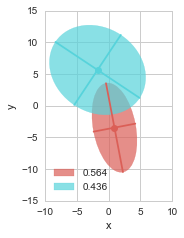

In [80]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [81]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points))
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmQZHd9J/h5mfnyqKz7PrOulhC0aJA4rAmhwILBYFm7
PQzttrtDkq2VxotiDGOxtlfAIrPjFsc4BrP2WjhsrSN2hI1okMOGhdlxeCyHx3hGWPRoZRpa0HVf
eVTlUXm/fMf+kf199cuX78yjKrN4nwhFq6pefvP3Mt/7vO/ve3y+nKIoCly4cOHilMJz0gtw4cKF
i3bCJTkXLlycargk58KFi1MNl+RcuHBxquGSnAsXLk41XJJz4cLFqYZLci5cuDjVcEnOhQsXpxou
yblw4eJUwyU5Fy5cnGq4JOfChYtTDZfkXLhwcarhkpwLFy5ONVySc+HCxamGS3IuXLg41XBJzoUL
F6caLsm5cOHiVMMlORcuXJxquCTnwoWLUw2X5Fy4cHGq4ZKcCxcuTjVcknPhwsWphktyLly4ONVw
Sc6FCxenGi7JuXDh4lTDd9ILcHHyUBQFgiBAFEV4vV7wPA+PxwOO4056aS5cNA1OURTlpBfh4uRQ
LpeRyWTQ19eHSqUCANjd3cXQ0BD6+vrg8Xhc0nPR1XA9uZ9gSJKEYrGIRCKBcDgMURTB8zwURYGi
KJAkCaIoQhAEcBwHr9frkp6LroNLcj+BUBQFoihCkiRwHAdJkrCysgJJkuDz+SDLMgqFAgKBAHy+
o0uESK9cLsPj8cDr9cLr9cLn87mk56Jj4W5Xf8IgyzIqlQroa9/b20MymUQkEoHf74cgCIhGo+A4
DpVKBT6fDz09PQiFQujp6YHX662xR3Y4jlPJzufz1R3nwsVJwfXkfkJA209JkgAAoihie3sbsiyD
53n09fVBEAQEg0HwPI+BgQGEw2GUy2UUCgVkMhnEYjGV9Ij4WDITRRGKoqBcLiMej2NiYgJ+v98l
PRcnCpfkfgIgyzJEUYQsy+A4DtlsFjs7OxgeHkZ/fz82Nzdrjuc4DoqigOM4BINBBINBDA8PQ1EU
lEolFItFpNNpRKNR8DyvEh5Levl8HoIgqKRH21vX03Nx3HBJ7pSD4miUTIhGozg8PMTc3JzqqdmN
WHAcp5IZS3qFQgHpdBp7e3vw+/3o6emBoigqqQJHcUCX9FwcN1ySO6WQZRmSJEGWZQCAIAjY2tqC
3+/H8vKymlBoJlnAkh69J3l6sixja2sLgUBAjeeFQiF4PNX6c5f0XBwXXJI7hZBlGfv7+8hkMohE
IkilUohGoxgfH8fw8HAdsWk9OdquOoXH41HjdYeHh5iamlIztclkEqVSCYFAoGZ7a0Z6uVwO/f39
CAQCLum5aBguyZ0y0PYUqBLH9vY2isUiFhcXEQwG645vZ9mHx+NBMBhET08PgCr5FotFFItFHBwc
oFwuIxgMqp5eMBisIb14PA6fzwdRFF1Pz0XDcEnulEBb+1apVJDL5TA4OIjl5WWVPIxeC7SX8IAq
6YXDYYTDYQBHpFcoFLC/v6+SHnl6lPwgz9Joe+v3+90aPReGcEnuFEBb+7a/v494PA6/34+ZmRnT
1+qRQ6PbVafQkh51YFAXhiiKiEajCIfDqqdnlcig3luX9FwQXJLrcpD3BlRJYmdnB6IoYnJyEoeH
h7ZsdEo9uNfrRW9vL3p7ewEAq6ur6O/vhyAIiMfjqFQqNZ6eHulVKhWUSiWV9DiOA8/z7vb2Jxgu
yXUptNvTXC6H7e1tDA4OIhKJIJ/P2yIvI4+nFcTXrA2O49DT04PBwUEAR55eoVBALBaDKIoq6fX0
9CAQCNSR3t7enmrD9fR+MuGSXBeCrX0DgFgshlQqhZmZGfT19anHNUoyrSCAdpCI1tMTRVElvWg0
ClEUa8pVAoGAuhYjT88lvdMPl+S6CIqi4ODgADzPIxgMolKpYHt7GxzHYXl5GTzPq8favWmPK/7W
Dvh8PvT19anEzpJeOp2GJElqwiUQCNQkKFjSo5geEZ9LeqcLLsl1Cag1K5VKqXGqnZ0djI6OYnR0
tO6mbJa8upH49Ehvd3dX/VeSpBqxAZb0ZFlWEzgs6fl8Pvh8Ppf0uhguyXUBJElSBS0BIJVKQRAE
zM/PqzVojYLIMJ/PI5PJqN0LpwFEUER8lUqlxtOTZVklvJ6enhoPjiW9SqWCbDaLiYkJl/S6EC7J
dTC0yYVSqYRcLodAIIAzZ86YZgztenJ0zPb2Nvr7+5FOp1EoFODz+SBJUl1nQjeD53nwPI/+/n4A
QKVSQaFQQLFYRDKZhKIoNZ4ekZ4oiigUCur2luM419PrIrgk16FglUMAIJlMIhaLIRgMYmBgwLIk
wg7JVSoVbG1tAQCWlpbU38fjcfV92c4E8njY0o1uBklKDQwMQFGUGk8vmUwCAEKhkCokSsXJQK2n
55JeZ8MluQ4EW/smyzJ2d3dRKpWwuLio3nzNgpVbKhQK4Hle3RJzHAe/34/h4WF1DXTza+vVtKUb
rUSryljsrI3O2e/315BeoVBANptFuVzG2tqarqcHuKTXyXBJroOg3Z4WCgVsbW2hr69Pbc2yuw01
Ok5RFMRiMaTTaczOzqK3txeJRMLUpl5nAm3ztKUbFNCn92oWJ0UOLOnxPI9kMomJiQkUCgXk83ns
7+/D4/HUlKwYkR5QLX+hh0O7Hgou9OGSXIdAW/uWSCSwv7+P6elpDAwMNGRTSzK0PfV4PDhz5kzN
/AYWVkTq9XrrspiFQqEmoK8oCnK5nDr4pptvakVR1B5Zv9+PwcFBdYxjoVBALpdDPB6H1+utIXvW
g5NlGfF4HOFwGH19fTVDgagzw0V74JLcCYMym3t7e4hEIpAkSZUlX15eVr0ighNPjgVtT0dGRupK
TpotN/H5fOjv768J6G9tbaFUKiGTyaidC6zHc1ywu111Co7jEAgEEAgEMDQ0VEN62WxWJT32vFnB
AT1Pj4YCuaTXWrgkd4Kg5AJNwCIiGhoawvj4eFPN83QcbU8zmYyqBtxukHcyOjqKQCCgxrZYj4e9
+Y08yk6BHaLUI71yuYxisYjDw0PEYjFVLRk4Smhot7eCIABA3VAgl/QaR2dfXacY7PaUpJF2dnbU
OJkRnHhdsixjdXUVXq+3Rg3YyKb231aAjW1pt3l085sNx+kENPJZsPMxiPQ2Nzfh8/nqhgKxk9CI
zGjokHbmrUt6zuGS3DFDT/dte3sbiqKYxsm0NqyQy+UgyzL6+/t1OyJOCnoeDzsch50TQd5NM2jV
drVZG5Rx7e/vV2dg0HlnMhlEo1H4/f6aRIYR6e3t7WFqaqpmElqnfL+dCJfkjhHaqVmZTAa7u7sY
Hh5WZ5xawepilmVZ3Z5yHIexsTFbazupNi7tcByaE1EoFCDLMjY3Nw3Vg48L7YjrORkKxE5C4zgO
xWJR7YJxPT1ruCR3TGBr3xRFwe7uLvL5PBYWFtQSBTsw20rSsBqfz4elpSXcvHnTtk3tz816UEBj
xKmdEzEzM6NmbxOJBARBqPF2uqkw2YwszYYCpVIp7O3tqUOBKHtNrwPc7a0ZXJJrM/Ras7a2thAK
hbC8vAyv1wtJkhyNBdQ7lrzCsbExjIyMqEkHJ+vsxBvBSD2Y1ZTT1uix53GcBcWttMOS/cjISI2H
qygK1tfXdYcCsaQniqJLenBJrq3QNtYfHBwgHo9jcnISQ0ND6u+dBPq1x8qyjGg0imw2W9ew78Rm
q9EqUtDCTFNOr+m+k8i7mbWwpJdMJrG0tIRyuYxCoWA5FAjQJ71yuYze3t5T35HhklwboCgKJEnC
9evXcebMGQDA7u4uBEHA0tKSKuZIcJrNpGPL5bI6S9WqYd+OTbrQu0ljTiuvpG26F0URBwcH6Ovr
U1uxnKLTiBK

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1wVOXZx//JLpG8LOHxAUIEFsJCqkQgL1RmWmLbaErr
2KpdcRM1Tmum1g+lY0UlakkQQ0Jbwxe0dnTKjIZRg/rBMnW0vPhMHsGxCXYDSeQlecgGEEJSCWR3
gU12z/MhnMPZzXm5z76ds7vXbyaju/e5z7kT9vz3uq/7Ov87jeM4DgRBECqk6z0AgiASAxILgiCY
ILEgCIIJEguCIJggsSAIggkSC4IgmDDrPQCCINgIBALYvHkzjh8/joyMDDQ2NmLhwoVC+4EDB/Da
a6/BbDbDbrfjoYceku3T29uL3/zmN1i0aBEAoLq6Gvfcc4/yADiCIBKCTz/9lNu4cSPHcRz373//
m3vyySeFNp/Px919993c6Ogod+3aNe4Xv/gFNzw8LNtn9+7d3N/+9jdN16fIgiAShMOHD6O8vBwA
UFxcjO7ubqGtv78fVqsVubm5AICysjJ0dHTA6XRK9unu7sapU6ewf/9+LFy4EC+88AJycnIUr5+Q
YnH48GG9h0AQAmVlZczHOp374ffPlG3PyMjA8uXLJdvcbnfQDW0ymTAxMQGz2Qy32w2LxSK0ZWdn
w+12y/ZZsWIF1q1bh9tvvx2vv/46XnvtNWzcuFFx7AkpFgDQtuUzvYcgydiYGxaLskIbBRpr5Djq
f6TpeL9/JuZZm2Tbzw6+INuWk5MDj8cjvA4EAjCbzZJtHo8HFotFtk9lZSVmzJgBAKisrMTLL7+s
OnZaDSGIBKG0tBTt7e0AAKfTicLCQqHNZrPB5XJhdHQUPp8PnZ2dKCkpke1TW1uLI0eOAAC++OIL
FBUVqV4/YSMLgkg1KisrcfDgQVRVVYHjODQ1NWHPnj3wer1wOByoq6tDbW0tOI6D3W5HXl6eZB8A
2Lx5M15++WVMmzYNs2bNYoosSCwIIkFIT0/Hli1bgt6z2WzC/1dUVKCiokK1DwAUFRXhvffe03Z9
TUcTBJGykFgQBMEEiQVBEEyQWBAEwQQlOBOIvpErmo5fMiszRiMhUhESCwMjJQ625Vamvv1HBxXF
hYSE0AqJhQER3+Ss4hCKUj9eSPx+wHQtWFBIRAg5SCwMRDREggX+3GNjY0HPE4RGIyQchBgSCwMQ
L5FQQ3xtsXCQaBCATqshXV1dqKmpAQD09vaivLwcNTU1qKmpwccff6zHkHSDvyFty626CkUo4vFo
TawSyUncI4s333wTf//735GZOflt1dPTg1/96ld4/PHH4z0U3RELhVGxLbdSlEEA0EEsrFYrduzY
geeeew5AeCYcyUAiCAUPP0ZeNEgwIuM/V0/qPYSwiLtYrF27FmfOnBFeh2PCAUz6GxgVtbF94538
b75tFsbGxuIwInm0XH/Oov/Cuf4RHB9y45asGA5KBiP/m2thAD+UbZsbv2FoRvcEZzgmHAAMaYQC
qJu09I1cQWGxMaKJ0NUQFizFFvQfHcTQtfhOSYxqfpNK6F7uHY4JR6KSLIlCSnymJrpHFuGYcCQi
iZSjYIFPfBKpgy5iMX/+fOzevRtAeCYciUayCQWPbbkVfUcHKeGZIug+DUl2klUoeGzLrTQdSRFI
LGJIsgsFDwlGakBiESNSRSjEkGAkNyQWMSAVhYJWSJIfEosowxdcpZJQ8JBgJDe6L50mE0aLKHpG
RxXb/X4/TNePKZopv6WeFgTBuL6sSislyQOJRZTghSLfNku3MUiJg61QvoCYr+DsP3E+qG80hEP8
ABoJRnJAYhFFbMutujzrIb7RlcRBDnEfXjhIMIhQKGcRBfpGrugy9egZHRWEwlY4NyyhCIU/h/jc
EZ2P8hhRIxAIoL6+Hg6HAzU1NXC5XEHtBw4cgN1uh8PhEIoe1frs2bMHDoeD6fokFhGix00QC5EQ
Iz4nCYZx2LdvH3w+H9ra2rBhwwZs27ZNaBsfH0dzczN27tyJ1tZWtLW1YWRkRLFPb28vPvjgA3Ac
x3R9EosoEM+oIpYiEQoJRmxweQdlf5Q4fPgwysvLAQDFxcXo7u4W2vr7+2G1WpGbm4uMjAyUlZWh
o6NDts/Fixexfft2vPDCC8zjppxFBMTzgx9pXiJcbIVzo5bHoBzGJJcC3wurn9vtDjKGMplMmJiY
gNlshtvtDrIbyM7Ohtvtluzj8/nw4osv4vnnn8dNN93EfH2KLCIkHlFFPKMJKfjrRiOPQRFG+OTk
5MDj8QivA4EAzGazZJvH44HFYpHsc+zYMbhcLmzevBlPP/00+vr6sHXrVtXrk1iESbw+7GKh0Jto
TUuMUoeSaJSWlqK9vR0A4HQ6UVhYKLTZbDa4XC6Mjo7C5/Ohs7MTJSUlkn1WrFiBf/zjH2htbcX2
7duxZMkSvPjii6rX12Ua0tXVhVdeeQWtra1wuVyoq6tDWloali5dioaGBqSnJ4aGxfpDbySh4InW
tIQeb9dOZWUlDh48iKqqKnAch6amJuzZswderxcOhwN1dXWora0Fx3Gw2+3Iy8uT7BMuurt7Nzc3
46mnnsLq1atRX1+P/fv3o7KyMt7D0kQ8ogojCgVPNPMYqZ6/0EJ6ejq2bNkS9J7NZhP+v6KiAhUV
Fap9xIi9ZdTQ3d27p6cHd9xxBwDgzjvvxMGDB5nEQk/zVr9f2Ww30sKsUz4fACB//oyoFHn1+b1B
r5eYbrjthnv+OfnZOHfmMo785z8oyMgI7xwaDYCTxbA3UdHd3ZvjOKSlpQGYzOCyfnj1Mm/tG7kC
kwmyRrfhmOCK6RkdhclkiiiiODI2EvTaZDJhacEc4fXJUxcAXH82xGQCAKywaC9Tt9w2WSo+6PeH
HWHwBsAWi3J0QYa9+qP70qk4P+HxeASnbyMTq1xFpFMPXiTEwiAF384L28lTF4S+WkUjGlMSyl8k
BrpnEpctW4Yvv/wSANDe3o5Vq1bpPCJ5YpmriEQojoyN4MjYCJYWzFEVCin4fksL5gjn0kK0Vklo
OdXY6C4WGzduxI4dO+BwODA+Po61a9fqPSRFYhFVRCoUgHo0wQp/Hq2iEalg0HKq8dHd3bugoAC7
du3SYxiaiPW3nhGEgoc/Hz89YZ2aRGNKQqsjxkX3yCKRiFVUoVUoIp12sCKOMliJJMKg6MLYkFjo
SDg3VKyiCTniLRgA5S6MCokFA7H0qwhn+hEvoRBfT2vyM1zBoOjCuJBY6ES4049whKLLOxz0Ey5a
o4xoPuJO6I/udRZGxyghsZZpgJQg3Dp/NgDg2JkbguHHBEzeq1iZNZv53EsL5mhKfPJJTy0ke93F
8cvnZNt+bOA70sBDMw7RDo21ftNqyVPwQsCLQyji9/mirK4zN8SFRTjCEYyeE+ej5iCe6JgDy/Ue
QljQNEQnWKcgrEIhnmLICYUct86fLfRhnaqI8xisaBVJo0R1xCQkFgrE4sMazvydRSiA4Js+HEJF
g3VsLIKhNT9DiU7jQWKhQiw+tFqjCiXCjSaU4EVDS5TBKhiU7ExcSCwMjlJUEQuhEKMlytA6JSES
DxKLOKLlW1VtmTTWQsGjNcpQEwyt0QXlLYwDrYbEmWg6X7EIRZdPfpnOb/bD5HNjZUY+07X4ZVe5
FROtqyRq8G7ghDEgsTAgrFGFEmKRuG2u9M3tHhvDac/VoGOVhEOLYBDJh2HE4oEHHhD2N5g/fz6a
m5t1HlF0iXZiTymq4G9+OZEQIz7m6/PDQl850WARDACK0QXVXSQmhhCLa9eugeM4tLa26j2UmBKN
KYhaVKFFKELh+6iJhppgUHSRnBgiwXns2DFcuXIFjz/+OB577DE4nU69h6QbLCsKclFFJEIh5ra5
s4VzyOU8WFZ

## Goodness-of-fit Statistics

In [82]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points))
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.981  0.026      0.027  1.529069e-08      0.027       0.194

# 5. GMM by Optimization

In [83]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print(FIT_METHOD)

square_error


In [84]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.901871120154826
     jac: array([  1.23874140e+00,  -2.38418579e-07,   2.38418579e-07,
         0.00000000e+00,   2.38418579e-07,   4.76837158e-07,
         1.23874545e+00,   0.00000000e+00,   2.38418579e-07,
         2.38418579e-07,  -2.38418579e-07,   1.66893005e-06,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 347
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([ 0.43305447,  0.58005336, -3.34067998,  3.27849687,  6.47888189,
       -0.18828631,  0.56694553, -0.67455653,  4.06325158,  7.56431227,
        8.01215596, -0.20140506])

## 5.1 GMM Result

In [85]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.567  -0.675   4.063  7.564  8.012  -0.201
2  0.433   0.580  -3.341  3.278  6.479  -0.188

GMM Plot Result
0.566945532757 [[-0.67455653  4.06325158]] [ 6.92905035  8.56748063] -142.973469459
0.433054467243 [[ 0.58005336 -3.34067998]] [ 3.20069746  6.51766737] -172.816396872


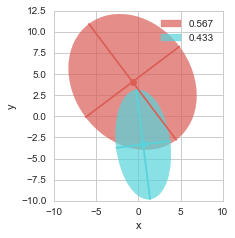

In [86]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)

## 5.2 Goodness-of-fit statistics

In [87]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.992  0.011      0.022  6.180472e-09      0.017       0.123

In [88]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAATkAAAE5CAYAAADr4VfxAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvWmQZGd5Lvick2tV1r53bV1LS8hISEhsmpF1GYFZLmam
jWm3rb6SbAVtrvVDDsRgrkAXmbBbLOZe7AiHhY37z4ywLdrIYYMh5jK2NWMbO8CoQ6NLQ8Ptyq69
cqtcKvc82/zIfk99efKsmSerMovzRCha3fXll9/JOufJd31eTlEUBR48ePBwQsEf9wE8ePDgoZPw
SM6DBw8nGh7JefDg4UTDIzkPHjycaHgk58GDhxMNj+Q8ePBwouGRnAcPHk40PJLz4MHDiYZHch48
eDjR8EjOgwcPJxoeyXnw4OFEwyM5Dx48nGh4JOfBg4cTDY/kPHjwcKLhkZwHDx5ONDyS8+DBw4mG
R3IePHg40fBIzoMHDycaHsl58ODhRMMjOQ8ePJxoeCTnwYOHEw2P5Dx48HCi4ZGcBw8eTjQ8kvPg
wcOJhkdyHjx4ONHwH/cBPBw/FEVBrVaDKIrw+XwIBALgeR4cxx330Tx4aBucoijKcR/Cw/GhWq0i
l8thcHAQgiAAAHZ3dzE6OorBwUHwPO+RnoeehmfJ/RRDkiSUy2Ukk0lEIhGIoohAIABFUaAoCiRJ
giiKqNVq4DgOPp/PIz0PPQeP5H4KoSgKRFGEJEngOA6SJGFtbQ2SJMHv90OWZZRKJYRCIfj9h7cI
kV61WgXP8/D5fPD5fPD7/R7peehaeO7qTxlkWYYgCKBf+97eHtLpNBYXFxEMBlGr1RCLxcBxHARB
gN/vR39/P/r6+tDf3w+fz9ewH+3DcZxKdn6/v2mdBw/HBc+S+ykBuZ+SJAEARFHE9vY2ZFlGIBDA
4OAgarUawuEwAoEAhoeHEYlEUK1WUSqVkMvlEI/HVdIj4mPJTBRFKIqCarWKRCKB6elpBINBj/Q8
HCs8kvspgCzLEEURsiyD4zjk83ns7OxgbGwMQ0ND2NzcbFjPcRwURQHHcQiHwwiHwxgbG4OiKKhU
KiiXy8hms4jFYggEAirhsaRXLBZRq9VU0iP31rP0PBw1PJI74aA4GiUTYrEYDg4OsLCwoFpqdiMW
HMepZMaSXqlUQjabxd7eHoLBIPr7+6EoikqqwGEc0CM9D0cNj+ROKGRZhiRJkGUZAFCr1bC1tYVg
MIjV1VU1odBOsoAlPXpPsvRkWcbW1hZCoZAaz+vr6wPP1+vPPdLzcFTwSO4EQpZlpFIp5HI5LC4u
IpPJIBaLYWpqCmNjY03EprXkyF11Cp7n1XjdwcEBTp06pWZq0+k0KpUKQqFQg3trRnqFQgFDQ0MI
hUIe6XloGR7JnTCQewrUiWN7exvlchnLy8sIh8NN6ztZ9sHzPMLhMPr7+wHUybdcLqNcLmN/fx/V
ahXhcFi19MLhcAPpJRIJ+P1+iKLoWXoeWoZHcicE2to3QRBQKBQwMjKC1dVVlTyMXgt0lvCAOulF
IhFEIhEAh6RXKpWQSqVU0iNLj5IfZFkaubfBYNCr0fNgCI/kTgC0tW+pVAqJRALBYBBzc3Omr9Uj
h1bdVafQkh51YFAXhiiKiMViiEQiqqVnlcig3luP9DwQPJLrcZD1BtRJYmdnB6IoYmZmBgcHB7b2
6JZ6cJ/Ph4GBAQwMDAAAotEohoaGUKvVkEgkIAhCg6WnR3qCIKBSqaikx3EcAoGA597+FMMjuR6F
1j0tFArY3t7GyMgIFhcXUSwWbZGXkcXjBvG1uwfHcejv78fIyAiAQ0uvVCohHo9DFEWV9Pr7+xEK
hZpIb29vT93Ds/R+OuGRXA+CrX0DgHg8jkwmg7m5OQwODqrrWiUZNwigEySitfREUVRJLxaLQRTF
hnKVUCiknsXI0vNI7+TDI7kegqIo2N/fRyAQQDgchiAI2N7eBsdxWF1dRSAQUNfafWiPKv7WCfj9
fgwODqrEzpJeNpuFJElqwiUUCjUkKFjSo5geEZ9HeicLHsn1CKg1K5PJqHGqnZ0dTExMYGJioumh
bJe8epH49Ehvd3dX/VOSpAaxAZb0ZFlWEzgs6fn9fvj9fo/0ehgeyfUAJElSBS0BIJPJoFar4fTp
02oNWqsgMiwWi8jlcmr3wkkAERQRnyAIDZaeLMsq4fX39zdYcCzpCYKAfD6P6elpj/R6EB7JdTG0
yYVKpYJCoYBQKIQzZ86YZgztWnK0Znt7G0NDQ8hmsyiVSvD7/ZAkqakzoZcRCAQQCAQwNDQEABAE
AaVSCeVyGel0GoqiNFh6RHqiKKJUKqnuLcdxnqXXQ/BIrkvBKocAQDqdRjweRzgcxvDwsGVJhB2S
EwQBW1tbAICVlRX13xOJhPq+bGcCWTxs6UYvgySlhoeHoShKg6WXTqcBAH19faqQKBUnA42Wnkd6
3Q2P5LoQbO2bLMvY3d1FpVLB8vKy+vC1C1ZuqVQqIRAIqC4xx3EIBoMYGxtTz0APv7ZeTVu64Sbc
KmOxcza65mAw2EB6pVIJ+Xwe1WoVN2/e1LX0AI/0uhkeyXURtO5pqVTC1tYWBgcH1dYsu26o0TpF
URCPx5HNZjE/P4+BgQEkk0nTPfU6E8jN05ZuUECf3qtdHBc5sKQXCASQTqcxPT2NUqmEYrGIVCoF
nucbSlaMSA+ol7/Ql0OnvhQ86MMjuS6BtvYtmUwilUphdnYWw8PDLe2pJRlyT3mex5kzZxrmN7Cw
IlKfz9eUxSyVSg0BfUVRUCgU1ME3vfxQK4qi9sgGg0GMjIyoYxxLpRIKhQISiQR8Pl8D2bMWnCzL
SCQSiEQiGBwcbBgKRJ0ZHjoDj+SOGZTZ3Nvbw+LiIiRJUmXJV1dXVauI4MSSY0Hu6fj4eFPJSbvl
Jn6/H0NDQw0B/a2tLVQqFeRyObVzgbV4jgp23VWn4DgOoVAIoVAIo6OjDaSXz+dV0mOvmxUc0LP0
aCiQR3ruwiO5YwQlF2gCFhHR6Ogopqam2mqep3XknuZyOVUNuNMg62RiYgKhUEiNbbEWD/vwG1mU
3QI7RKlHetVqFeVyGQcHB4jH46paMnCY0NC6t7VaDQCahgJ5pNc6uvvuOsFg3VOSRtrZ2VHjZEZw
YnXJsoxoNAqfz9egBmy0p/ZPN8DGtrRuHj38ZsNxugGtfBbsfAwivc3NTfj9/qahQOwkNCIzGjqk
nXnrkZ5zeCR3xNDTfdve3oaiKKZxMu0eVigUCpBlGUNDQ7odEccFPYuHHY7Dzokg66YduOWutrsH
ZVyHhobUGRh03blcDrFYDMFgsCGRYUR6e3t7OHXqVMMktG75/XYjPJI7QminZuVyOezu7mJsbEyd
cWoFq5tZlmXVPeU4DpOTk7bOdlxtXNrhODQnolQqQZZlbG5uGqoHHxU6EddzMhSInYTGcRzK5bLa
BeNZetbwSO6IwNa+KYqC3d1dFItFLC0tqSUKdmDmStKwGr/fj5WVFdy4ccP2ntq/t2tBAa0Rp3ZO
xNzcnJq9TSaTqNVqDdZOLxUmm5Gl2VCgTCaDvb09dSgQZa/pdYDn3prBI7kOQ681a2trC319fVhd
XYXP54MkSY7GAuqtJatwcnIS4+PjatLByTm78UEwUg9mNeW0NXrsdRxlQbGb+7BkPz4+3mDhKoqC
9fV13aFALOmJouiRHjyS6yi0jfX7+/tIJBKYmZnB6Oio+u9OAv3atbIsIxaLIZ/PNzXsO9nTbbhF
ClqYacrpNd13E3m3cxaW9NLpNFZWVlCtVlEqlSyHAgH6pFetVjEwMHDiOzI8kusAFEWBJEm4du0a
zpw5AwDY3d1FrVbDysqKKuZIcJrNpLXValWdpWrVsG9nT7rRe0ljTiuvpG26F0UR+/v7GBwcVFux
nKLbiBJoJD3

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAADSCAYAAABdE+UBAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnW1wVOXZx//JLpG8LOHxAUIEFsJCqkQgL1RmWmLbaErr
2KpdcRM1Tmum1g+lY0UlakkQQ0Jbwxe0dnTKjIZRg/rBMnW0vPhMHsGxCXYDSeQlecgGEEJSCWR3
gU12z/MhnMPZzXm5z76ds7vXbyaju/e5z7kT9vz3uq/7Ov87jeM4DgRBECqk6z0AgiASAxILgiCY
ILEgCIIJEguCIJggsSAIggkSC4IgmDDrPQCCINgIBALYvHkzjh8/joyMDDQ2NmLhwoVC+4EDB/Da
a6/BbDbDbrfjoYceku3T29uL3/zmN1i0aBEAoLq6Gvfcc4/yADiCIBKCTz/9lNu4cSPHcRz373//
m3vyySeFNp/Px919993c6Ogod+3aNe4Xv/gFNzw8LNtn9+7d3N/+9jdN16fIgiAShMOHD6O8vBwA
UFxcjO7ubqGtv78fVqsVubm5AICysjJ0dHTA6XRK9unu7sapU6ewf/9+LFy4EC+88AJycnIUr5+Q
YnH48GG9h0AQAmVlZczHOp374ffPlG3PyMjA8uXLJdvcbnfQDW0ymTAxMQGz2Qy32w2LxSK0ZWdn
w+12y/ZZsWIF1q1bh9tvvx2vv/46XnvtNWzcuFFx7AkpFgDQtuUzvYcgydiYGxaLskIbBRpr5Djq
f6TpeL9/JuZZm2Tbzw6+INuWk5MDj8cjvA4EAjCbzZJtHo8HFotFtk9lZSVmzJgBAKisrMTLL7+s
OnZaDSGIBKG0tBTt7e0AAKfTicLCQqHNZrPB5XJhdHQUPp8PnZ2dKCkpke1TW1uLI0eOAAC++OIL
FBUVqV4/YSMLgkg1KisrcfDgQVRVVYHjODQ1NWHPnj3wer1wOByoq6tDbW0tOI6D3W5HXl6eZB8A
2Lx5M15++WVMmzYNs2bNYoosSCwIIkFIT0/Hli1bgt6z2WzC/1dUVKCiokK1DwAUFRXhvffe03Z9
TUcTBJGykFgQBMEEiQVBEEyQWBAEwQQlOBOIvpErmo5fMiszRiMhUhESCwMjJQ625Vamvv1HBxXF
hYSE0AqJhQER3+Ss4hCKUj9eSPx+wHQtWFBIRAg5SCwMRDREggX+3GNjY0HPE4RGIyQchBgSCwMQ
L5FQQ3xtsXCQaBCATqshXV1dqKmpAQD09vaivLwcNTU1qKmpwccff6zHkHSDvyFty626CkUo4vFo
TawSyUncI4s333wTf//735GZOflt1dPTg1/96ld4/PHH4z0U3RELhVGxLbdSlEEA0EEsrFYrduzY
geeeew5AeCYcyUAiCAUPP0ZeNEgwIuM/V0/qPYSwiLtYrF27FmfOnBFeh2PCAUz6GxgVtbF94538
b75tFsbGxuIwInm0XH/Oov/Cuf4RHB9y45asGA5KBiP/m2thAD+UbZsbv2FoRvcEZzgmHAAMaYQC
qJu09I1cQWGxMaKJ0NUQFizFFvQfHcTQtfhOSYxqfpNK6F7uHY4JR6KSLIlCSnymJrpHFuGYcCQi
iZSjYIFPfBKpgy5iMX/+fOzevRtAeCYciUayCQWPbbkVfUcHKeGZIug+DUl2klUoeGzLrTQdSRFI
LGJIsgsFDwlGakBiESNSRSjEkGAkNyQWMSAVhYJWSJIfEosowxdcpZJQ8JBgJDe6L50mE0aLKHpG
RxXb/X4/TNePKZopv6WeFgTBuL6sSislyQOJRZTghSLfNku3MUiJg61QvoCYr+DsP3E+qG80hEP8
ABoJRnJAYhFFbMutujzrIb7RlcRBDnEfXjhIMIhQKGcRBfpGrugy9egZHRWEwlY4NyyhCIU/h/jc
EZ2P8hhRIxAIoL6+Hg6HAzU1NXC5XEHtBw4cgN1uh8PhEIoe1frs2bMHDoeD6fokFhGix00QC5EQ
Iz4nCYZx2LdvH3w+H9ra2rBhwwZs27ZNaBsfH0dzczN27tyJ1tZWtLW1YWRkRLFPb28vPvjgA3Ac
x3R9EosoEM+oIpYiEQoJRmxweQdlf5Q4fPgwysvLAQDFxcXo7u4W2vr7+2G1WpGbm4uMjAyUlZWh
o6NDts/Fixexfft2vPDCC8zjppxFBMTzgx9pXiJcbIVzo5bHoBzGJJcC3wurn9vtDjKGMplMmJiY
gNlshtvtDrIbyM7Ohtvtluzj8/nw4osv4vnnn8dNN93EfH2KLCIkHlFFPKMJKfjrRiOPQRFG+OTk
5MDj8QivA4EAzGazZJvH44HFYpHsc+zYMbhcLmzevBlPP/00+vr6sHXrVtXrk1iESbw+7GKh0Jto
TUuMUoeSaJSWlqK9vR0A4HQ6UVhYKLTZbDa4XC6Mjo7C5/Ohs7MTJSUlkn1WrFiBf/zjH2htbcX2
7duxZMkSvPjii6rX12Ua0tXVhVdeeQWtra1wuVyoq6tDWloali5dioaGBqSnJ4aGxfpDbySh4InW
tIQeb9dOZWUlDh48iKqqKnAch6amJuzZswderxcOhwN1dXWora0Fx3Gw2+3Iy8uT7BMuurt7Nzc3
46mnnsLq1atRX1+P/fv3o7KyMt7D0kQ8ogojCgVPNPMYqZ6/0EJ6ejq2bNkS9J7NZhP+v6KiAhUV
Fap9xIi9ZdTQ3d27p6cHd9xxBwDgzjvvxMGDB5nEQk/zVr9f2Ww30sKsUz4fACB//oyoFHn1+b1B
r5eYbrjthnv+OfnZOHfmMo785z8oyMgI7xwaDYCTxbA3UdHd3ZvjOKSlpQGYzOCyfnj1Mm/tG7kC
kwmyRrfhmOCK6RkdhclkiiiiODI2EvTaZDJhacEc4fXJUxcAXH82xGQCAKywaC9Tt9w2WSo+6PeH
HWHwBsAWi3J0QYa9+qP70qk4P+HxeASnbyMTq1xFpFMPXiTEwiAF384L28lTF4S+WkUjGlMSyl8k
BrpnEpctW4Yvv/wSANDe3o5Vq1bpPCJ5YpmriEQojoyN4MjYCJYWzFEVCin4fksL5gjn0kK0Vklo
OdXY6C4WGzduxI4dO+BwODA+Po61a9fqPSRFYhFVRCoUgHo0wQp/Hq2iEalg0HKq8dHd3bugoAC7
du3SYxiaiPW3nhGEgoc/Hz89YZ2aRGNKQqsjxkX3yCKRiFVUoVUoIp12sCKOMliJJMKg6MLYkFjo
SDg3VKyiCTniLRgA5S6MCokFA7H0qwhn+hEvoRBfT2vyM1zBoOjCuJBY6ES4049whKLLOxz0Ey5a
o4xoPuJO6I/udRZGxyghsZZpgJQg3Dp/NgDg2JkbguHHBEzeq1iZNZv53EsL5mhKfPJJTy0ke93F
8cvnZNt+bOA70sBDMw7RDo21ftNqyVPwQsCLQyji9/mirK4zN8SFRTjCEYyeE+ej5iCe6JgDy/Ue
QljQNEQnWKcgrEIhnmLICYUct86fLfRhnaqI8xisaBVJo0R1xCQkFgrE4sMazvydRSiA4Js+HEJF
g3VsLIKhNT9DiU7jQWKhQiw+tFqjCiXCjSaU4EVDS5TBKhiU7ExcSCwMjlJUEQuhEKMlytA6JSES
DxKLOKLlW1VtmTTWQsGjNcpQEwyt0QXlLYwDrYbEmWg6X7EIRZdPfpnOb/bD5HNjZUY+07X4ZVe5
FROtqyRq8G7ghDEgsTAgrFGFEmKRuG2u9M3tHhvDac/VoGOVhEOLYBDJh2HE4oEHHhD2N5g/fz6a
m5t1HlF0iXZiTymq4G9+OZEQIz7m6/PDQl850WARDACK0QXVXSQmhhCLa9eugeM4tLa26j2UmBKN
KYhaVKFFKELh+6iJhppgUHSRnBgiwXns2DFcuXIFjz/+OB577DE4nU69h6QbLCsKclFFJEIh5ra5
s4VzyOU8WFZ

In [89]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


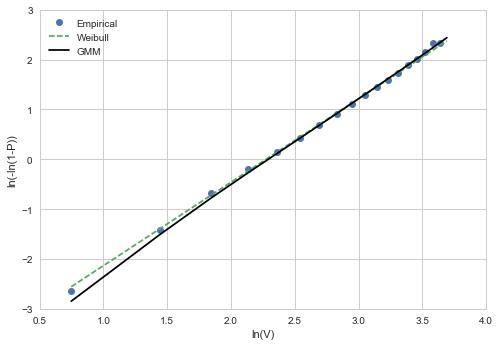

In [90]:
x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(df.speed)

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y_cdf_gmm = array(list(zip(*y_))[0])

plot(log(x), log(-log(1-y_ecdf)),'o', label = 'Empirical')
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')
plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label = 'GMM')
plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Speed Distribution Comparison


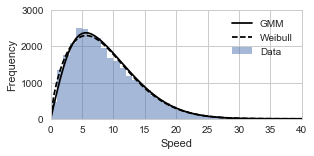

In [91]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y_gmm = array(list(zip(*y_))[0])*len(df.speed)/0.02

# 2. Weibull
y_weibul = sp.stats.weibull_min.pdf(x, *weibull_params)

df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')
plot(x, y_gmm,'-', color='black', label='GMM')
plot(x, y_weibul*len(df.speed), '--', color='black', label='Weibull') 
print('Speed Distribution Comparison')
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)

Direction Distribution Comparison


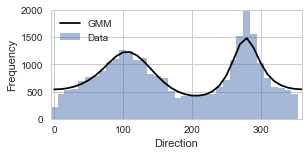

In [92]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]
y = array(list(zip(*y_))[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print(title)

In [93]:
# %%time
incre = max(SECTOR_LENGTH, 10)
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(gmm, df, angle, incre) 
                                        for angle in arange(0, 360, incre))  
# This R square is computed as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
print(true_R_square(density_collection))

0.908265019835


## 5.3 Sectoral Comaprison

In [94]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        # 1. Get Weibull and ECDF
        x, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed)
        # 2. Get GMM PDF, CDF
        _, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)
        
        fig = plt.figure(figsize=(13,1.3))
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')                  
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        print('%s (%s - %s) degree' % (angle, start_angle, end_angle))

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'], bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                            for x_ in bins[:-1]]
        density_expected_gmm = array(list(zip(*density_expected_ ))[0])/direction_prob
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.weibull_min.cdf(bins[1:], *weibull_params) - sp.stats.weibull_min.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob, 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print('data size:', len(sub_df), 'weight', len(sub_df)/len(df))
        print('GMM', 'Weibull')
        print('R square', R_square_gmm,  R_square_weibull)
        print('max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()])
        print(' ')
    return max_diff_array, curve_collection

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: RuntimeWarning: divide by zero encountered in log


5.0 (-5.0 - 15.0) degree


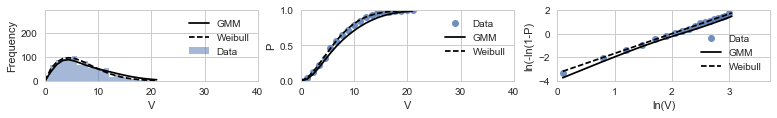

data size: 914 weight 0.031755958585226875
GMM Weibull
R square 0.901447513327 0.946828985231
max diff: 0.0929745605428 0.022559431874 speed value: 12.1463157895 y gmm 0.815121719545
 
25.0 (15.0 - 35.0) degree


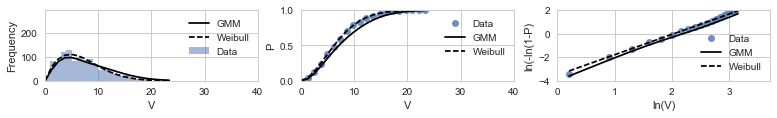

data size: 1072 weight 0.03724550066013481
GMM Weibull
R square 0.902089357931 0.947748079206
max diff: 0.0994959103398 0.0135840176273 speed value: 9.83157894737 y gmm 0.685019015033
 
45.0 (35.0 - 55.0) degree


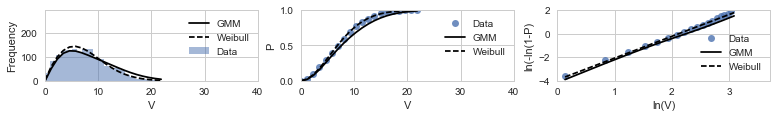

data size: 1465 weight 0.05089986797303871
GMM Weibull
R square 0.930705021303 0.971778298439
max diff: 0.0873273811511 0.0161037257427 speed value: 10.3405263158 y gmm 0.686051458439
 
65.0 (55.0 - 75.0) degree


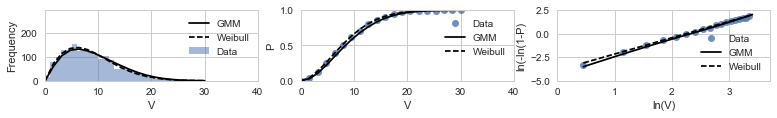

data size: 1668 weight 0.0579528872211799
GMM Weibull
R square 0.971414830001 0.980837793963
max diff: 0.0419507835817 0.0261322738592 speed value: 6.32 y gmm 0.345938904668
 
85.0 (75.0 - 95.0) degree


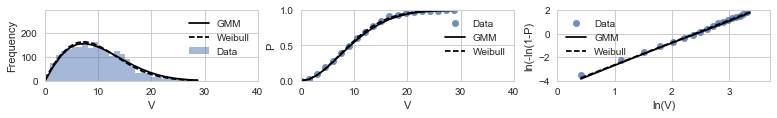

data size: 2145 weight 0.07452574525745258
GMM Weibull
R square 0.957660260028 0.957378142662
max diff: 0.0404675721189 0.0203533185043 speed value: 16.6273684211 y gmm 0.870021938371
 
105.0 (95.0 - 115.0) degree


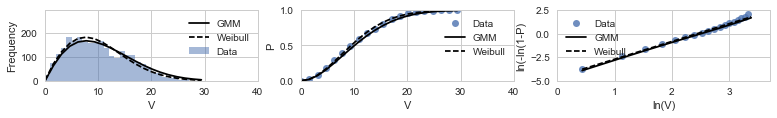

data size: 2514 weight 0.0873462580779654
GMM Weibull
R square 0.947154123258 0.946309582059
max diff: 0.049478227702 0.0312769338664 speed value: 7.73421052632 y gmm 0.350283108814
 
125.0 (115.0 - 135.0) degree


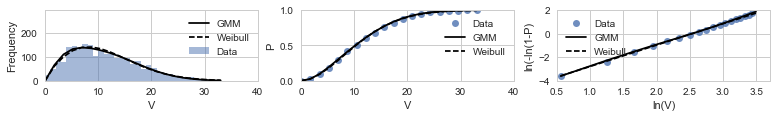

data size: 2204 weight 0.07657563755124731
GMM Weibull
R square 0.956071631916 0.949879890022
max diff: 0.0193021340286 0.0187513198918 speed value: 17.3842105263 y gmm 0.836452769237
 
145.0 (135.0 - 155.0) degree


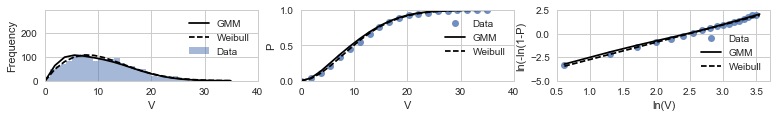

data size: 1606 weight 0.055798763115836286
GMM Weibull
R square 0.945815469987 0.969622970397
max diff: 0.0442137266824 0.0192941112519 speed value: 7.35368421053 y gmm 0.375471509995
 
165.0 (155.0 - 175.0) degree


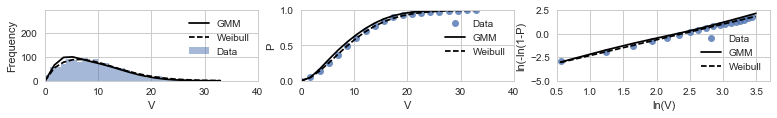

data size: 1264 weight 0.04391633659926343
GMM Weibull
R square 0.920398185159 0.972210800066
max diff: 0.0689016288574 0.0135979961589 speed value: 6.94105263158 y gmm 0.43282567949
 
185.0 (175.0 - 195.0) degree


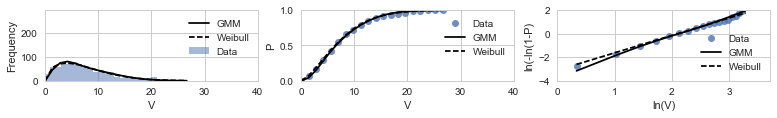

data size: 813 weight 0.02824682092974776
GMM Weibull
R square 0.953662281195 0.964995923251
max diff: 0.0225880149546 0.0249650293359 speed value: 19.6294736842 y gmm 0.981997609051
 
205.0 (195.0 - 215.0) degree


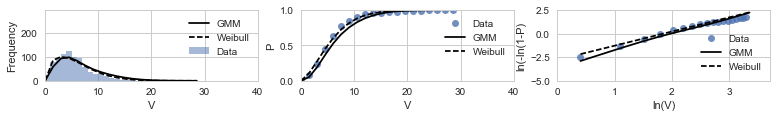

data size: 854 weight 0.029671322354249182
GMM Weibull
R square 0.930596200456 0.939184278499
max diff: 0.116564971549 0.0479972468199 speed value: 7.51315789474 y gmm 0.656268752105
 
225.0 (215.0 - 235.0) degree


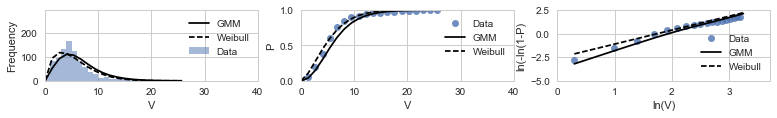

data size: 913 weight 0.031721214648043915
GMM Weibull
R square 0.867310851429 0.894831941443
max diff: 0.144807553542 0.0900089431494 speed value: 5.4 y gmm 0.466364407028
 
245.0 (235.0 - 255.0) degree


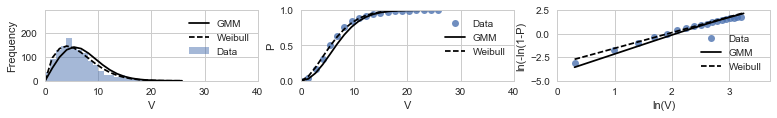

data size: 1289 weight 0.044784935028837465
GMM Weibull
R square 0.88540515037 0.9688891765
max diff: 0.126041366964 0.0267987667849 speed value: 5.42315789474 y gmm 0.374346530631
 
265.0 (255.0 - 275.0) degree


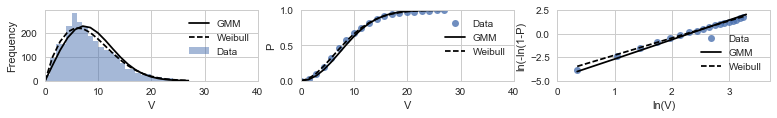

data size: 2590 weight 0.08998679730387048
GMM Weibull
R square 0.908588029632 0.958641563849
max diff: 0.0794362980405 0.0224684651863 speed value: 7.09210526316 y gmm 0.387359068755
 
285.0 (275.0 - 295.0) degree


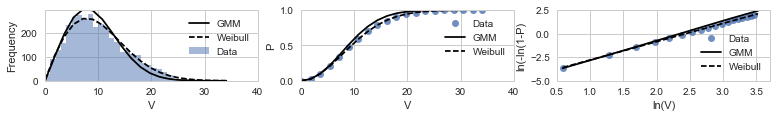

data size: 3555 weight 0.12351469668542839
GMM Weibull
R square 0.949861396514 0.982125400309
max diff: 0.0722427139351 0.0179835195655 speed value: 14.3494736842 y gmm 0.856771546565
 
305.0 (295.0 - 315.0) degree


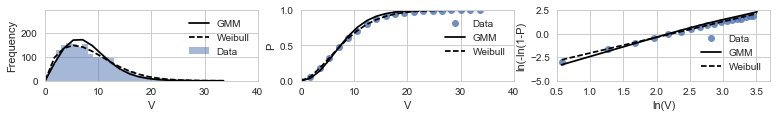

data size: 1778 weight 0.061774720311305674
GMM Weibull
R square 0.934222145418 0.975819876063
max diff: 0.0520381926776 0.0126203541636 speed value: 12.3678947368 y gmm 0.851250791103
 
325.0 (315.0 - 335.0) degree


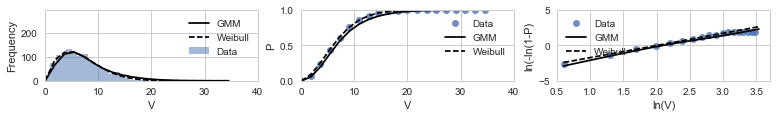

data size: 1150 weight 0.03995552776040581
GMM Weibull
R square 0.973872713898 0.988996069121
max diff: 0.0554116214548 0.016568077125 speed value: 9.09210526316 y gmm 0.70284924811
 
345.0 (335.0 - 355.0) degree


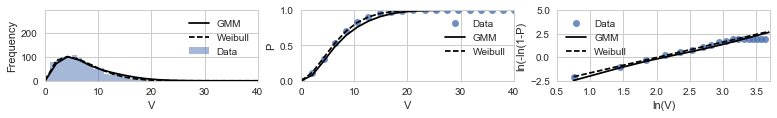

data size: 988 weight 0.03432700993676603
GMM Weibull
R square 0.965217706176 0.985633526054
max diff: 0.069240925126 0.014929322638 speed value: 8.44842105263 y gmm 0.642297536412
 
Wall time: 44.7 s


In [95]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

0.9369561444417671 0.9633202789046141


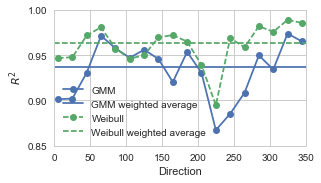

In [96]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")
ylim = min(plt.gca().get_ylim()[0],0.85)
plt.gca().set_ylim(top=1, bottom=ylim)
print(gmm_mean, weibull_mean)

0.06605469474282545 0.023296760356975352


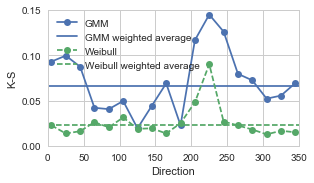

In [97]:
gmm_mean, weibull_mean = plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim, bottom=0)
print(gmm_mean, weibull_mean)

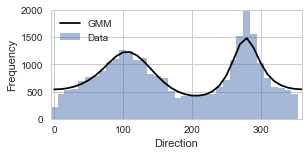

In [98]:
# Compare direction weight with previous figure
display(dir_fig)

## 5.4 Insufficient-fit Sector Investigation

### 5.4.1 Data Variability, by Bootstrap (Resampling)

In [99]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [100]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
# weibull_params = sp.stats.weibull_min.fit(sub_df.speed, loc=0)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


225.0 (215.0 - 235.0) Degree Speed Distribution
0.165989170225 5.5 0.478041497902


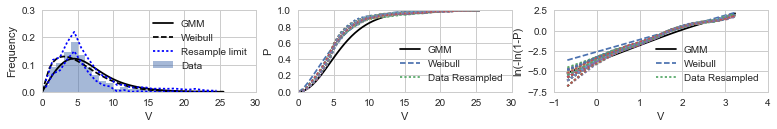

In [101]:
x = arange(0, sub_max_speed, 0.5)
_, y_weibull, y_cdf_weibull, weibull_params, y_ecdf = fit_weibull_and_ecdf(sub_df.speed, x)
_, y_gmm, y_cdf_gmm, direction_prob = gmm_integration_in_direction(f, angle_radian-incre_radian/2, angle_radian+incre_radian/2, x)

fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_cdf_gmm,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color = 'black',label='GMM')

# 3. Weilbull 
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_cdf_weibull,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in range(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_cdf_gmm)
print(diff.max(), x[diff.argmax()], y_cdf_gmm[diff.argmax()])

### 5.4.2 Time Variability

In [102]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

ax2.plot(x, y_cdf_gmm,'-', color='black', label = 'GMM')
ax2.plot(x, y_cdf_weibull,'--', label='Weibull')

ax3.plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black',label='GMM')
ax3.plot(log(x), log(-log(1-y_cdf_weibull)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in range(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print('%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle))
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: divide by zero encountered in log


225.0 (215.0 - 235.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuYHGWZ9/+tPs5Mz6Hn0DPJTGYmM0kgJGEAg8SI5oeG
CKL8dNGgAVEJArLsq1ne9Q1mCUcXlKwsXC5hXVkVDysKLyi4BFbCIWxEBBQwkcBkMplkkkwfp3v6
XF3V9f4xPJWna6qqq6qrZ7qn63NdXjKT6erq6u7nW/f93Pf3ZgRBEGBhYWFhYWGhim2uT8DCwsLC
wqIasATTwsLCwsJCA5ZgWlhYWFhYaMASTAsLCwsLCw1YgmlhYWFhYaEBSzAtLCwsLCw0YAmmhYWF
hYWFBizBtLCwsLCw0IAlmBYWFhYWFhqwBNPCwsLCwkIDlmBaWFhYWFhowBJMCwsLCwsLDViCaWFh
YWFhoQFLMC0sLCwsLDRgCaaFhYWFhYUGLMG0sLCwsJg1jh49iq997Wu49NJL8cUvfhHXXHMNhoeH
8b3vfQ+nnXYa/H6/+LfhcBgrV67EY489hvHxcZx66qn493//94LjffWrX8UVV1wxK+duCaaFhYWF
xayQTqdx3XXX4corr8SvfvUr/OQnP8Hf/d3f4fbbbwcALF68GLt27RL//qmnnsLChQvFn/v6+vDM
M8+IP09OTmJsbGzWzt8xa89kYWFhYVExfOMb38Ajjzxi6jE3btyIHTt2KP77888/jw984AM466yz
xN8NDQ3hJz/5Cf71X/8VF110EZ5++ml8+ctfFv/+Ix/5iPi3ra2t8Hq9GBkZwZIlS7Br1y5ceOGF
eO2110x9HUpYEaaFhYWFxawwPj6Ovr4+8efrrrsOV1xxBS688EJMTEygo6MD9fX1OHr0KMbGxrBg
wQK43e6CY3ziE5/Af/3XfwEAdu/ejfPPP3/Wzt+KMC0sLCxqkB07dqhGg+VgwYIF2Ldvn/jzAw88
AAC49NJLwfM8gJOCyHEcLr74Yuzdu7fgGOeffz4uv/xyXHLJJfD5fKirq5u187ciTAsLCwuLWWH9
+vV4+eWX8cYbb4i/Gxsbw8TEBBiGAQBccMEF2L17N1577TWsWbNmxjE8Hg8GBgawY8cOfPKTn5y1
cwcswbSwsLCwmCU8Hg8eeOABPPTQQ/jCF76Az3/+89i2bRu++c1voru7GwDQ1NSEBQsWYMWKFbDZ
5CXq4osvxuuvv461a9fO5umDEQRBmNVntLCwsLCwqEKsCNPCwsLCwkIDlmBaWFhYWFhowKqStahJ
8vk8OI4Dy7Kw2+2w2Wyw2+2w2+1i8YGFhYUFjSWYFjVFPp+H3+9Ha2ur+LMgCBAEAclkEvF4HN3d
3bDZbGAYxhJSCwsLEUswLWqCfD4PnueRz+dx4sQJeL1e5PN55HI5OJ1OUQyJgJKeMFITxzCMKKCW
kFpY1CaWYFrMa0jqlS4GFwQBwWAQkUgEDMOA53m4XC7YbDZwHIdkMgmXywWHw1EghlqF1OFwiD9b
WFjMH6yiH4t5Cc/zYFkWLMuK4sZxnDgJgWVZDAwMYGBgAIODg+js7ITb7YYgCJicnMSRI0cwMjKC
I0eOYGJiApOTk0gmk6L4EqEETgopx3HIZrNiajeRSCCVSiGdTiObzYLneVhdXBa1zJe+9CW89dZb
AKa/g6tXr8aDDz4o/vsVV1yBt99+e8bj9uzZg1/+8pcYHx/HpZdeqvn5zj33XPG4IyMjJZ69FWFa
zDN4nhdTr0TUOI5DKBTC5OQkmpubYbPZsHDhQtjtdrHop76+HoIgIJvNYtGiReKxstksWJZFNptF
IpEQBdjtdsPlcsHlcon/XSwizWazAACbzSZGoCSta0WkFrXAueeei9deew1DQ0N4/fXX8aEPfQgv
vvgivvKVryCbzeLYsWNYvnz5jMetW7cOwLQX7VxiCabFvEBOKHO5HEKhEKLRKFpaWrBkyRK4XC7E
4/GClKoSdrsdDQ0NaGhoKPg9qa4lYppIJJDNZsEwTIGAkv+W7nPSQprL5cSIleyL0v9tCalFOVm8
eObvNm0C7rrL2L8fPqz+fB/84Aexc+dObN68GS+++CI2btyIf/7nf0Y8Hsf+/ftxzjnn4NVXX8W/
/Mu/wG63o7e3F7fffjuefPJJHDp0CJ///OcRiUTw1a9+FeFwGOeddx6uv/563Hjjjbjooouwbt06
7NmzB0899RS+/e1v67sYGrAE06KqkRNKlmURCoUQi8Xg9XqxdOlSOJ3OosdiGEZTytThcMDhcBQI
KRFBIqKZTAZTU1NgWRYMw4giSospEUc6tctxnPjfREhp4eR5XlaELSyqgRUrVuDQoUMQBAGvvvoq
brjhBqxduxa///3v8c477+BDH/oQtm/fjv/8z/9Ee3s77r33Xjz++ONwOE5KVSqVwo4dO9DQ0IDL
L78c69evn7XztwTTouoQBKGg6pUWymAwiKmpKbS2tmLZsmUFXzSCVmHUA8MwopB6PJ6CcyV7myzL
Ip1OIxqNiqlgWkTJ/xNxpCt38/k8AODgwYNYvHixWFgkLTaiH2dhUYxiEWGp/y7FZrNh+fLl2LNn
D3w+H1wuF9atW4cXXngBBw4cwOWXX47t27djy5YtAIBMJoMPfvCD6O/vF4+xfPlyNDU1AQBOP/10
jI6OFjxHOesELMG0qBqUhDKbzSIYDCIej6OtrU1RKAlKglkuIXU6nTMiXEEQkMvlxMKkVColCqnD
4ZixP0qElBwTKBRSOsWstEdqYVEJnHvuufj+97+PT3ziEwCA1atXY+fOnQCmB0QvWLAAO3fuRFNT
E3bv3o2GhgacOHFCfPzIyAiSySTcbjfeeustfO5zn8PLL7+MYDAIAPjrX/9atnO3BNOi4iFCKa1Q
zWazCAQCSCQSmoRSylxGYmS/0+VyFfyeCCm9P8qyLHK5HBwOB/L5PCKRCOrq6sTHS6NKWkhZlhWf
Tyqk0iIlC4vZ4IMf/CBuuukm3H333QAAl8uFpqYmnHbaabDZbPjHf/xHXHPNNRAEAR6PB3fffXeB
YLa0tODv//7vEYlEcNFFF2Hp0qXYuHEjtm3bhieffBKL5TZeTcKaVmJRsQiCgHQ6jVgshtbWVnFx
z2QyCAaDSCQSaG9vR3t7O+x2u+bjDg8Po7e3F3V1daKgAEA2m8WJEyfK+oUziiAIYFkWR44cgdfr
FUWV4zg4nc4ZqV3ajEHpeMBMIXU4HNb+qIWFAlaEaVFxkAIanueRyWQwOTmJtrY2pNNpBINBpFIp
tLe3o7u7W5dQEsqRei03pHCIYRi0tbWJr5u4FZGIlBQaESGV7o8SIdUTkVquRhYW01iCaVEx0EJJ
t1rwPI+xsTGk02l0dHRg0aJFJe/JzdYeZrmx2Wxwu91wu90Fv8/n8wWtL2R/lLgaSVtf5AqGiJDS
14Skcy17QItaxBJMizlHTigZhkEqlcLExARYlkV7ezt6e3tNKV6phcXdZrOhrq4OdXV1Bb+nHZCy
2SxSqRSy2Szy+bxs64vcPqfUHpA8H0nr5nI51NXVFU0LW1hUG5ZgWswZSkKZTCYRCATAsixaW1uR
y+XQ3t5u2vPOZpVspUFcjerr6wt+T4RUWmwkCIJs64uaGcPhw4fR3d0tppAtw3qL+YIlmBazjpxQ
AkAikUAgEADHcfD5fGJxy+TkpKnPTwtjLYikFpSEtJirkVRM7XZ7wXtqTX6xmE9Ygmkxa9Am5cDJ
1Gg8HkcgEADP8+js7ERLS4v4b7MpaJZ4zsSIqxHd+qIlIlVK7VqTXywqDUswLcoOMRsgCyQRpqmp
KQSDQeTzeXR2dqK5uXnGwlguM4F8Po94PI5YLCZWkxqpuK1FirkajY2NweFwIJPJIBaLaXI1oo9h
GdZbVCqWYFq

### 5.4.3 Adjacent Sector Variability

In [103]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [104]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[list(curves)[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print(max_diff_angle) 
print('GMM, Weibull, Histogram')
align_figures()

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


225.0
GMM, Weibull, Histogram


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAE5CAYAAAAdhBAsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXuYHGWdNnxX9Xl6zudzMkkGQhIiMWASw0ZZYMOiXKgL
USJBOSjmc8XgtyogATV4IoB4sYZVWHUJrCG8guJy8H0Nxxf4FIwGCQSSmcwkk8z0uXv6XN1V9f0x
PJWna6q6q7ura3pm6r6uXJnpnn6ep6qrnrt+p/vHiKIowoQJEyZMmDCRF+xML8CECRMmTJiYDTAJ
04QJEyZMmNAAkzBNmDBhwoQJDTAJ04QJEyZMmNAAkzBNmDBhwoQJDTAJ04QJEyZMmNAAkzBNmDBh
woQJDTAJ04QJEyZMmNAAkzBNmDBhwoQJDTAJ04QJEyZMmNAAkzBNmDBhwoQJDTAJ04QJEyZMmNAA
kzBNmDBhwoQJDTAJ04QJEyZMmNAAkzBNmDBhwoQJDTAJ04QJEyZMGIbjx4/jhhtuwKZNm3DVVVfh
i1/8Ig4fPoz77rsPZ5xxBjwej/S3gUAAy5cvx+OPP46xsTGcfvrp+PnPf54z3pe+9CVs2bLFkLWb
hGnChAkTJgxBMpnE1q1bcfXVV2Pv3r146KGH8K//+q/47ne/CwBYuHAhnnnmGenvn376aXR1dUm/
9/f34w9/+IP0eygUwujoqGHrtxo2kwkTJkyYqBp8/etfx2OPPabrmJdffjl27typ+v7zzz+PtWvX
YtWqVdJrK1euxEMPPYR///d/x8UXX4xnn30Wn//856W/P++886S/bWpqQmNjI4aGhrB48WI888wz
uOiii/DGG2/oehxqMC1MEyZMmDBhCMbGxtDf3y/9vnXrVmzZsgUXXXQRJiYm0NraCpfLhePHj2N0
dBSdnZ1wOBw5Y3zsYx/DU089BQDYt28fLrjgAsPWb1qYJkyYMDEPsXPnzrzWYCXQ2dmJt956S/r9
/vvvBwBs2rQJPM8DOEWI2WwWl1xyCV555ZWcMS644AJ89rOfxac+9Sm0tbXB6XQatn7TwjRhwoQJ
E4bg/PPPx2uvvYa//e1v0mujo6OYmJgAwzAAgI0bN2Lfvn144403sGbNmmljuN1uDAwMYOfOnfj4
xz9u2NoBkzBNmDBhwoRBcLvduP/++/Ff//VfuPLKK/GZz3wGt9xyC26++WZ0d3cDAOrq6tDZ2Yll
y5aBZZUp6pJLLsFf/vIXrFu3zsjlgxFFUTR0RhMmTJgwYWIWwrQwTZgwYcKECQ0wCdOECRMmTJjQ
ADNL1sS8hCAIyGaz4DgOFosFLMvCYrHAYrFIyQcmTJgwQcMkTBPzCoIgwOPxoKmpSfpdFEWIooh4
PI5oNIru7m6wLAuGYUwiNWHChASTME3MCwiCAJ7nIQgCxsfH0djYCEEQkMlkYLPZJDIkBEpqwkhO
HMMwEoGaRGrCxPyESZgm5jSI65VOBhdFET6fD8FgEAzDgOd52O12sCyLbDaLeDwOu90Oq9WaQ4Za
idRqtUq/mzBhYu7ATPoxMSfB8zw4jgPHcRK5ZbNZqRMCx3EYGBjAwMAAFi1ahPb2djgcDoiiiFAo
hGPHjmFoaAjHjh3DxMQEQqEQ4vG4RL6EKIFTRJrNZpFOpyXXbiwWQyKRQDKZRDqdBs/zMKu4TMxn
fO5zn8Obb74JYOoeXL16NR588EHp/S1btuCdd96Z9rmXXnoJjz76KMbGxrBp0ybN861fv14ad2ho
qMzVmxamiTkGnucl1yshtWw2C7/fj1AohPr6erAsi66uLlgsFinpx+VyQRRFpNNp9Pb2SmOl02lw
HId0Oo1YLCYRsMPhgN1uh91ul34uZJGm02lks1mEQiF0dXWBYRjJrWtapCbmA9avX4833ngDK1eu
xF/+8hece+65ePHFF3HdddchnU7jxIkTWLp06bTPbdiwAcCUFu1MwiRME3MCSkSZyWTg9/sRDofR
0NCAxYsXw263IxqN5rhU1WCxWFBTU4Oampqc10l2LSHTWCyGdDoNhmFyCJT8TMc5SXIRIdJMJiNZ
rCQuSv9sEqmJSmLhwumvXXEF8IMflPb+yEj++T784Q9j165duOaaa/Diiy/i8ssvx1133YVoNIqD
Bw/iQx/6EF5//XX8+Mc/hsViQV9fH7773e/i97//PYaHh/GZz3wGwWAQX/rSlxAIBPDRj34UX/7y
l3HTTTfh4osvxoYNG/DSSy/h6aefxg9/+MPiToYGmIRpYlZDiSg5joPf70ckEkFjYyOWLFkCm81W
cCyGYTS5TK1WK6xWaw6REmuSkGgqlcLk5CQ4jgPDMBKJWiwWKQGJkCNNptlsVvqZEClNnCaRmpjN
WLZsGYaHhyGKIl5//XV87Wtfw7p16/Dqq6/i3Xffxbnnnovt27fjv//7v9HS0oJ7770XTzzxBKzW
U1SVSCSwc+dO1NTU4LOf/SzOP/98w9ZvEqaJWQdRFHOyXmmi9Pl8mJycRFNTEwYHB3NuNAKtxFgM
GIaRiNTtdueslcQ2OY5DMpmEIAgYHh6GxWLJsUjJ/4QM6cxdQRCk8ch8LMtOSzaiP2fCRCEUsgjL
fV8OlmWxdOlSvPTSS2hra4PdbseGDRvwwgsv4NChQ/jsZz+L7du3Y9u2bQCAVCqFD3/4w1iwYIE0
xtKlS1FXVwcAOPPMM3H06NGcOSqZJ2ASpolZAzWiTKfT8Pl8iEajaG5uViVKAjXCrBSR2mw2ycLl
OA4nTpzAwoULkclkpMSkRCKBcDgMjuNgtVqnxUdpIiXIR6TxeBwulwtOp1OySE2YqAasX78eP/vZ
z/Cxj30MALB69Wrs2rULwFSD6M7OTuzatQt1dXXYt28fampqMD4+Ln1+aGgI8XgcDocDb775Jj79
6U/jtddeg8/nAwC8/fbbFVu7SZgmqh6EKIPBIMLhMPr7+yWi9Hq9iMVimohSjpmwxAgpk3in3W7P
eV8URWQymZz4KMdxyGQysFqt06xRu90+zaoUBAGBQABNTU2qFqnFYpmWpGTChBH48Ic/jFtvvRV3
3nknAMBut6Ourg5nnHEGWJbFt771LXzxi1+EKIpwu9248847cwizoaEBN954I4LBIC6++GIsWbIE
l19+OW655Rb8/ve/x0KlwKtOMLuVmKhakLggKceIxWIIBALo7OyEz+dDLBZDS0sLWlpaYLFYNI97
+PBh9PX1wel0guM46fV0Oo3x8fGK3nCZTAbHjx/HokWLivqcKIqSNUpn7mazWdhstmmuXY/Hg+bm
5hz3sHw8YDqRWq1WU4zBhAkVmBamiaqDnCjpGGUymcTIyAhaWlrQ3d1dFFESVML1WmmQxCGHwyHF
bwBIakWEREmiUSaTgcfjgcvlyiFTomqk5tolDxA0kZqqRiZMTMEkTBNVAzWiTCQS8Pl8SCQSYFkW
g4ODZcfkjIphVhosy0pESuP48eOora0Fy7LgOE6KjxJVI3npi1LCECFS+pwQdy75W+JaNonUxHyA
SZgmZhz5iNLr9SKVSqGtrQ0tLS3weDxlk+VMb+5GkbLdbp/mkqUVkNLpNBKJBNLpNARBUIyPKsU5
SQ0pz/MYGhqSHmBMnV0Tcx0mYZqYMagRZTweh9frBcdxaGtrQ39/P1iWRTKZ1IVsjMySVZrDKCjN
RVSNXC5XzuuESOXJRqIoKpa+yK1MU7DexHyASZgmDIcSUQJALBaD1+tFNptFW1sbGhsbczZWvQiN
Hmc2umErATUizadqZLPZIIoiwuGwoqoRoF2w3iRSE7MBJmGaMAy0SDlwygKKRqPwer3geR7t7e1o
aGhQ3TgrSW4meU5HPlWjZDKJiYkJVVUjJYtUPgb5mUBJjMFUNTJRLTAJ00TFwfM8QqEQamtrAZwi
psnJSfh8Pgi

# 6. Result Variability & Cross-Validation

In [70]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.453   1.299   4.276  5.828  7.740  -0.281
2  0.231   0.760  -5.110  3.071  6.934  -0.387
3  0.206  -4.815   0.352  7.534  9.117  -0.694
4  0.110   0.223  -1.505  3.019  4.431   0.269

GMM Plot Result
0.452971231504 [[ 1.29867574  4.2762951 ]] [ 5.36732     8.06605232] -157.835265629
0.2309913971 [[ 0.76010828 -5.10955619]] [ 2.78431064  7.05383689] -168.457828246
0.205922400934 [[-4.81484134  0.35204172]] [  4.52524275  10.92719645] -142.726881539
0.110114970462 [[ 0.22345932 -1.50490537]] [ 2.82882974  4.55450191] 162.824821614


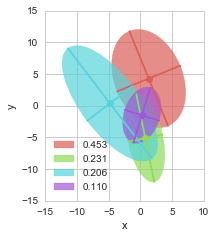

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.005      0.042  1.995863e-09      0.010       0.070

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.045  2.185633e-09      0.010       0.073

weight  mean_x   mean_y  sig_x  sig_y    corr
1  0.503   0.670    1.940  5.535  6.576  -0.045
2  0.215   0.188   -3.641  2.729  4.675  -0.086
3  0.182  -5.889    9.426  7.267  7.277   0.144
4  0.101   3.490  -11.954  3.475  5.399   0.065

GMM Plot Result
0.503151575522 [[ 0.66997435  1.9395458 ]] [ 5.51607268  6.59221072] -172.725561856
0.214691032727 [[ 0.18752986 -3.64093673]] [ 2.71404795  4.68413677] -175.684946823
0.181557293873 [[-5.8885699   9.42586123]] [ 6.727089   7.7795135] 135.269086785
0.100600097878 [[  3.48991463 -11.95385046]] [ 3.46270486  5.40681249] 175.934725984


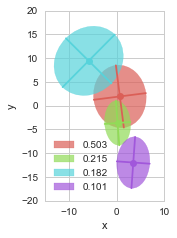

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.002968      0.008  1.773090e-09      0.009       0.066

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.004715      0.010  2.171273e-09      0.010       0.073

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.386   1.643   5.214  5.910  8.063  -0.339
2  0.262   0.927  -5.406  3.193  7.170  -0.380
3  0.233  -4.793   1.588  6.983  7.747  -0.574
4  0.119   0.147  -1.420  3.250  4.340   0.290

GMM Plot Result
0.385888357697 [[ 1.64283904  5.21353232]] [ 5.28317476  8.48746706] -156.490387029
0.261971382158 [[ 0.927391   -5.40583206]] [ 2.90467644  7.29126174] -168.557287686
0.233422109892 [[-4.79317484  1.58808942]] [ 4.77829796  9.2704609 ] -140.139374449
0.118718150254 [[ 0.14703095 -1.42041596]] [ 2.97990702  4.5293706 ] 157.65991342


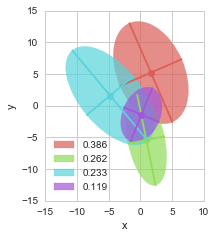

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.004789      0.105  1.808509e-09      0.009       0.067

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.007      0.042  2.116387e-09      0.010       0.072

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.552  -1.256   4.225  7.032  7.437  -0.186
2  0.258   0.281  -3.090  2.695  5.735  -0.118
3  0.173   3.419  -6.732  3.477  9.664  -0.092
4  0.017  -3.441  -3.229  2.301  1.824  -0.151

GMM Plot Result
0.551556052519 [[-1.25556255  4.22539773]] [ 6.49866607  7.90777313] -143.38467133
0.258468660044 [[ 0.28069114 -3.0901984 ]] [ 2.6713227   5.74622817] -175.945918105
0.173096486202 [[ 3.41882263 -6.73220248]] [ 3.46031308  9.66958477] -177.832101872
0.0168788012339 [[-3.44052357 -3.22883817]] [ 1.77179584  2.34140021] -106.389301854


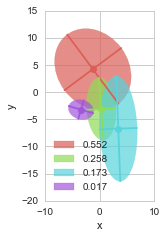

R_square       K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.003378      0.008  1.376186e-09      0.008       0.058

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.005      0.007  1.769300e-09      0.009       0.066

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.454   1.316   3.824  5.660  7.456  -0.185
2  0.241  -4.348   1.098  7.481  9.398  -0.623
3  0.197   1.532  -5.388  2.936  7.563  -0.301
4  0.108  -0.550  -3.000  2.425  4.053   0.081

GMM Plot Result
0.45370545772 [[ 1.31609245  3.82378549]] [ 5.44761249  7.61286592] -163.2127876
0.240702155737 [[-4.34797607  1.09814553]] [  5.04623487  10.90032663] -145.139751063
0.197457036662 [[ 1.53179945 -5.38766322]] [ 2.7780176   7.62276665] -172.296498524
0.108135349881 [[-0.55010854 -2.99969192]] [ 2.41304243  4.06057077] 175.714595608


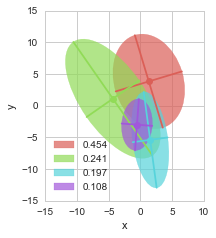

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.006      0.021  2.061714e-09      0.010       0.071

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.005      0.016  2.368510e-09      0.011       0.076

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.500   0.021   4.256  6.777  8.192  -0.260
2  0.234   0.625  -5.156  3.202  7.950  -0.488
3  0.160   0.882  -1.262  3.409  5.187   0.362
4  0.105  -3.637  -1.450  7.876  7.568  -0.827

GMM Plot Result
0.500276468797 [[ 0.02070657  4.25555307]] [ 6.21483696  8.62595965] -153.147840851
0.234403415537 [[ 0.62492269 -5.15614722]] [ 2.73571656  8.122739  ] -167.433831498
0.160114113588 [[ 0.88230791 -1.26239226]] [ 3.04851123  5.40695529] 160.029084038
0.105206002078 [[-3.63681588 -1.44978304]] [  3.20611752  10.44182945] -133.619925919


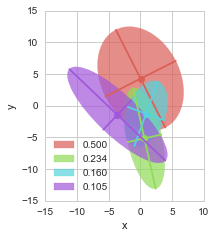

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.006      0.017  2.020627e-09      0.010       0.071

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.006      0.016  2.159681e-09      0.010       0.073

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.557  -0.657   4.235  7.025  8.037  -0.252
2  0.231   0.732  -1.601  3.221  5.244   0.120
3  0.171   1.130  -7.386  3.226  7.706  -0.504
4  0.041  -2.954  -3.184  7.726  6.440  -0.922

GMM Plot Result
0.557341456371 [[-0.65722109  4.23479088]] [ 6.39166249  8.54952069] -149.10044233
0.231127347111 [[ 0.73220752 -1.60112488]] [ 3.18452489  5.26636313] 173.351182553
0.170584733865 [[ 1.12974476 -7.38622356]] [ 2.71838236  7.89933305] -166.449119001
0.0409464626527 [[-2.95370298 -3.18403292]] [ 1.94712585  9.86762978] -129.384188093


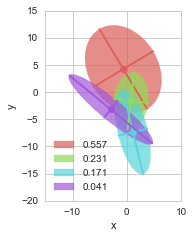

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.009      0.011  1.844099e-09      0.009       0.067

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.006      0.010  1.896395e-09      0.010       0.068

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.534  -0.358   4.420  7.074  8.121  -0.268
2  0.208   0.925  -6.090  3.157  7.519  -0.468
3  0.201   0.656  -1.299  3.451  5.258   0.255
4  0.056  -2.655  -2.865  7.795  6.551  -0.890

GMM Plot Result
0.534436647085 [[-0.35846447  4.41991849]] [ 6.37809458  8.67800611] -148.671223505
0.208194250363 [[ 0.92507199 -6.09037403]] [ 2.72954148  7.68470959] -167.248916366
0.201175439266 [[ 0.65575931 -1.29900623]] [ 3.26313156  5.37719505] 164.756591386
0.056193663286 [[-2.65472568 -2.86505923]] [ 2.35188704  9.90683138] -129.444599236


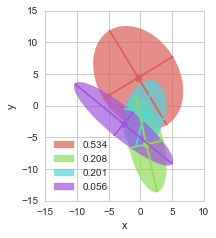

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.008      0.012  1.911949e-09      0.010       0.069

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.008      0.013  1.987859e-09      0.010       0.070

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.496   0.224   4.600  6.643  8.106  -0.275
2  0.247   0.702  -5.393  3.261  7.451  -0.435
3  0.144   0.979  -1.073  3.301  5.070   0.340
4  0.114  -4.380  -0.546  7.997  7.196  -0.788

GMM Plot Result
0.49588785292 [[ 0.22423569  4.6004339 ]] [ 6.0483045   8.55890236] -153.014248182
0.24683563543 [[ 0.70241674 -5.39299854]] [ 2.87660911  7.60805797] -167.397333842
0.143701665791 [[ 0.97926282 -1.07322092]] [ 2.99331216  5.25796108] 161.215024623
0.113574845859 [[-4.38017295 -0.54620501]] [  3.48128818  10.17897568] -131.180542869


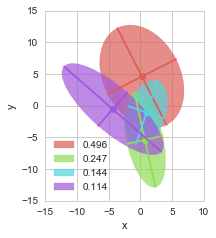

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.007      0.035  1.698927e-09      0.009       0.065

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.009      0.024  2.022265e-09      0.010       0.071

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.469  -0.185   3.239  6.396  6.260  -0.058
2  0.311   1.621  -5.584  3.503  7.450  -0.236
3  0.114  -5.973  12.928  7.286  7.490   0.317
4  0.106  -0.569  -3.003  2.519  3.744   0.045

GMM Plot Result
0.468867805543 [[-0.18467418  3.23854614]] [ 6.12869249  6.52214735] -124.930497284
0.311120813315 [[ 1.62147716 -5.58397338]] [ 3.37766568  7.50762302] -172.050229635
0.11440728744 [[ -5.97251998  12.9275944 ]] [ 6.10366814  8.48181801] 137.494995948
0.105604093701 [[-0.56851765 -3.00309252]] [ 2.51438295  3.74745116] 176.858958864


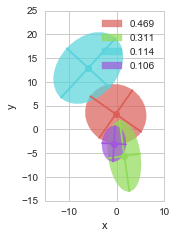

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.998  0.007      0.016  2.015992e-09      0.010       0.071

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.997  0.010      0.014  2.315655e-09      0.011       0.076


Wall time: 55.2 s


In [71]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df, FIT_METHOD, NUMBER_OF_GAUSSIAN, config) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print('')

## 6.2 Cross-validation, to select the number of Gaussian

In [72]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print('Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold) 

for number_of_gaussian in gaussian_number_range:
    print( '  ')
    print('Number of gaussian', number_of_gaussian)
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index, FIT_METHOD, number_of_gaussian, config) for train_index, test_index in kf)                        

    CV_result_train, CV_result_test = list(zip(*CV_result))
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print('Train')
    pretty_pd_display(CV_result_train)
    print('Test')
    pretty_pd_display(CV_result_test)

Number of train/test dataset 21586.5 7195.5
  
Number of gaussian 1
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.096267  0.058231  6.568732e-08    0.055522     0.402449  0.920293
1    0.096318  0.056866  6.105145e-08    0.054428     0.387451  0.925561
2    0.096059  0.056660  6.448916e-08    0.055958     0.398640  0.921307
3    0.095803  0.056834  6.335410e-08    0.055144     0.394977  0.922785

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.106671  0.063161  6.420461e-08    0.057455     0.396949  0.921102
1    0.101619  0.056007  6.909864e-08    0.056660     0.413514  0.916266
2    0.101632  0.047955  6.233954e-08    0.053765     0.391498  0.924678
3    0.097940  0.061676  6.516107e-08    0.055917     0.400684  0.920853

  
Number of gaussian 2
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.022941  0.012079  6.268313e-09    0.017271     0.124197  0.992343
1    0.021578  0.011158  6.060128e-09    0.017019     0.122166  0.992641
2    0.022454  0.010848  6.671769e-09    0.018211     0.128264  0.991793
3    0.022089  0.011105  6.117896e-09    0.016948     0.122725  0.992621

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.028044  0.014318  8.305022e-09    0.020223     0.143193  0.989991
1    0.027468  0.012031  8.146629e-09    0.019898     0.141652  0.989997
2    0.023933  0.011545  7.629502e-09    0.018186     0.136823  0.990995
3    0.025019  0.012700  8.093267e-09    0.020385     0.141263  0.989856

  
Number of gaussian 3
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.009068  0.006958  2.479043e-09    0.010901     0.078138  0.996986
1    0.011569  0.007438  2.782591e-09    0.011614     0.082759  0.996600
2    0.022269  0.010025  4.223428e-09    0.014345     0.102028  0.994839
3    0.010989  0.006654  2.679352e-09    0.011206     0.081224  0.996753

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.022099  0.013945  4.975398e-09    0.015435     0.110693  0.993922
1    0.012116  0.016431  3.889519e-09    0.013461     0.097959  0.995317
2    0.036453  0.013363  9.861668e-09    0.021274     0.155660  0.988144
3    0.012064  0.012745  4.084435e-09    0.014521     0.100329  0.994955

  
Number of gaussian 4
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.013227  0.005771  1.613182e-09    0.008693     0.063017  0.998044
1    0.018099  0.007356  1.777585e-09    0.009212     0.066146  0.997836
2    0.028603  0.004628  2.160601e-09    0.010254     0.072979  0.997352
3    0.052450  0.004265  1.733984e-09    0.009196     0.065354  0.997890

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.020784  0.016791  5.240826e-09    0.016392     0.113688  0.993542
1    0.018738  0.016572  3.712329e-09    0.013457     0.095702  0.995477
2    0.056273  0.012678  3.697469e-09    0.013052     0.095298  0.995587
3    0.068976  0.007030  4.908681e-09    0.014991     0.109925  0.994016

  
Number of gaussian 5
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.006994  0.006058  8.861541e-10    0.006425     0.046719  0.998921
1    0.033202  0.004501  1.180839e-09    0.007573     0.053919  0.998553
2    0.005992  0.005086  9.072853e-10    0.006665     0.047274  0.998891
3    0.038693  0.003520  1.066404e-09    0.007149     0.051250  0.998714

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.013195  0.006950  3.031917e-09    0.012608     0.086399  0.996315
1    0.031628  0.011101  3.609228e-09    0.012934     0.094325  0.995693
2    0.013359  0.011829  3.777410e-09    0.013074     0.096431  0.995456
3    0.039611  0.011551  4.470620e-09    0.014681     0.104920  0.994399

Wall time: 1min 42s


In [73]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print('Train gof mean, std')
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print('Test gof mean, std')
display(test_scores_mean)

Train gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.096112  0.057147  6.364551e-08    0.055263     0.395880  0.922486
2    0.022265  0.011298  6.279526e-09    0.017362     0.124338  0.992350
3    0.013474  0.007769  3.041104e-09    0.012017     0.086037  0.996294
4    0.028095  0.005505  1.821338e-09    0.009339     0.066874  0.997781
5    0.021220  0.004791  1.010170e-09    0.006953     0.049790  0.998770

Test gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.101966  0.057200  6.520096e-08    0.055949     0.400661  0.920725
2    0.026116  0.012649  8.043605e-09    0.019673     0.140733  0.990210
3    0.020683  0.014121  5.702755e-09    0.016173     0.116160  0.993084
4    0.041193  0.013268  4.389826e-09    0.014473     0.103653  0.994656
5    0.024448  0.010358  3.722294e-09    0.013324     0.095519  0.995466

R_square


D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


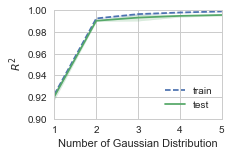

K_S


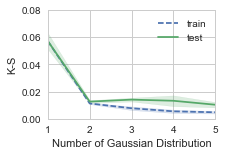

Chi_square


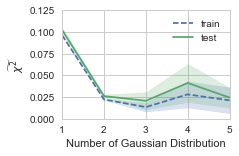

In [74]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '--', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print(column)
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Gaussian Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    if column == 'R_square':
        plt.gca().set_ylim(top=1)
    if column == 'K_S' or column == 'Chi_square':
        plt.gca().set_ylim(bottom=0)
    plt.show()

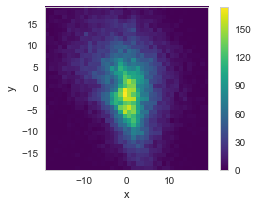

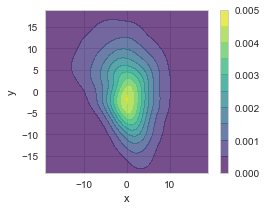

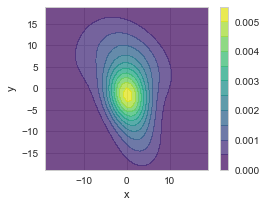

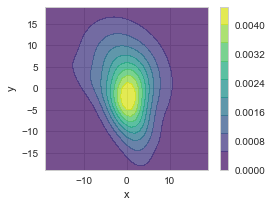

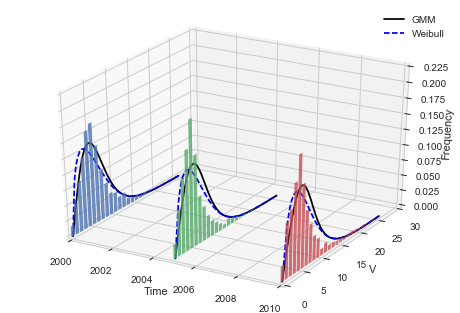

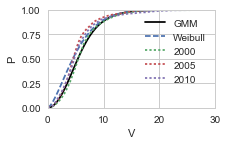

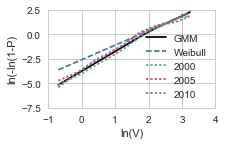

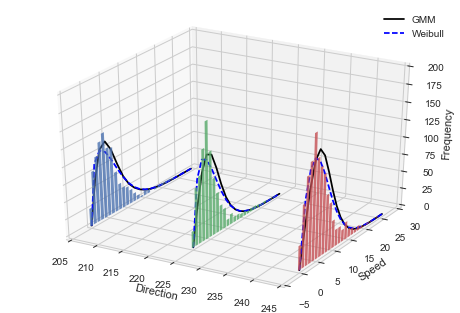

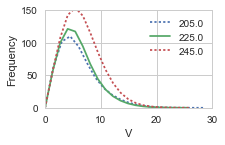

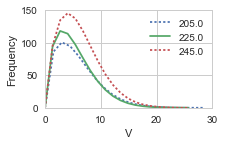

In [75]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [76]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(file_path)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)